In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [4]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [5]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [6]:
# nsamples = 5000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [7]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

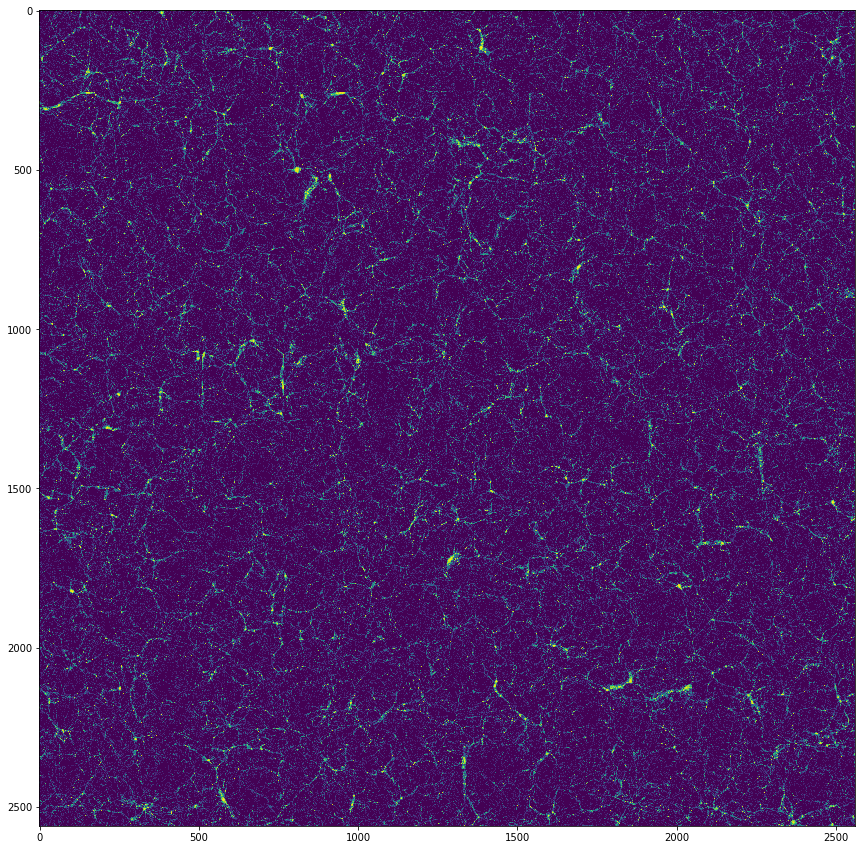

In [8]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [9]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

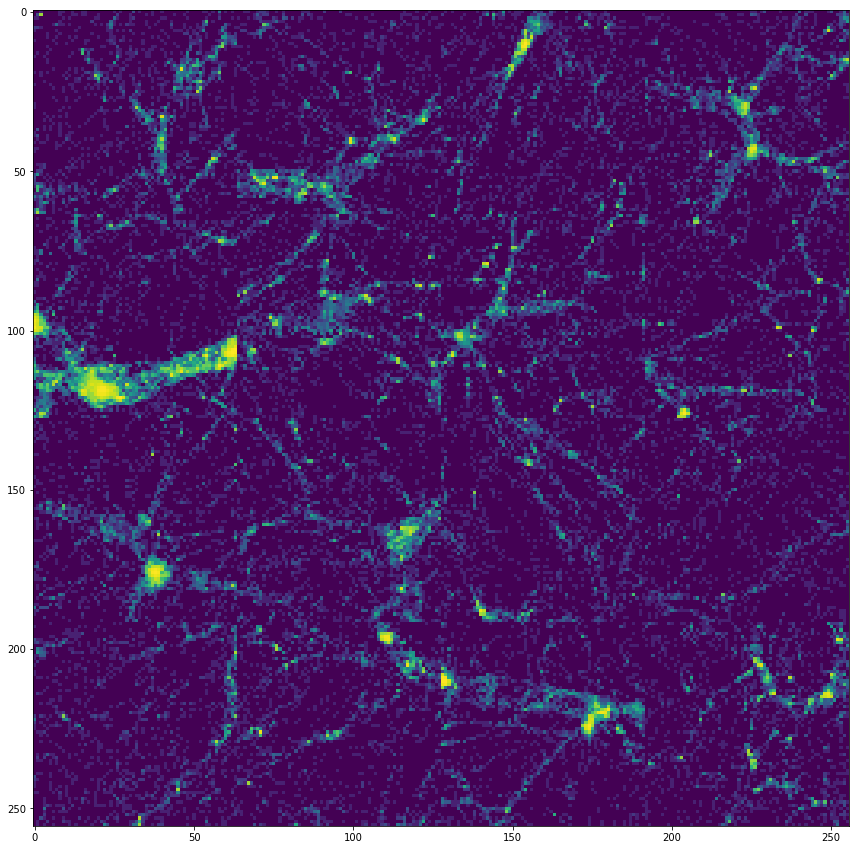

In [10]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [11]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str()
# time_str = '2018_1_5_11_26'

In [12]:
latent_dim = 100

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [3, 3]]
params_discriminator['batch_norm'] = [True, True, True]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_encoder = dict()
params_encoder['stride'] = [2, 2, 2]
params_encoder['nfilter'] = [16, 32, 64]
params_encoder['shape'] = [[5, 5],[5, 5], [3, 3]]
params_encoder['batch_norm'] = [True, True, True]
params_encoder['full'] = [128]
params_encoder['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2]
params_generator['latent_dim'] = latent_dim
params_generator['nfilter'] = [64, 32, 1]
params_generator['shape'] = [[3, 3],[5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True]
params_generator['full'] = [8*8*64]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['weight_l2'] = 0.1
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['encoder'] = params_encoder
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
global_path = '../../saved_result/WVEEGAN/'+ time_str +'_size_{}/'.format(ns)
params['summary_dir'] = global_path + 'summary/'
params['save_dir'] = global_path + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [ ]:
from model import veegan_model
from gan import WVEEGAN

# class gan_model(object):
#     def __init__(self, name='wgan'):
#         self.name = name
#     def generator(self, z, reuse):
#         return generator(z, self.params['generator'], reuse=reuse)
#     def discriminator(self, X, reuse):
#         return discriminator(X, self.params['discriminator'], reuse=reuse)
#     def __call__(self, params, z, X):
#         self.params = params
#         G_fake = self.generator(z, reuse=False)
#         D_real = self.discriminator(X, reuse=False)
#         D_fake = self.discriminator(G_fake, reuse=True)       
    
#         return G_fake, D_real, D_fake

veegan_model = veegan_model()
wveegan_obj = WVEEGAN(params, veegan_model)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 32, 32, 32)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 1)
------------------------------------------------------------

Encoder 
------------------------------------------------------------
     The input is of size (?, 64, 64, 1)
     0 Conv layer with 16 channels
         Batch norm
         Size of the variables: (?, 32, 32, 16)
     1 Conv layer with 32 channels
         Batch norm
         Size of the variables: (?, 16, 16, 32)
     2 Conv layer with 64 channels
         Bat

In [ ]:
wveegan_obj.train(img_small)


Epoch: [ 0] [  99/15000] Counter:100	( 0.3 min	86.92 examples/sec	0.184 sec/batch)	L_Disc:181.47994995	L_Gen:4.55400181
Epoch: [ 0] [ 199/15000] Counter:200	( 0.5 min	147.87 examples/sec	0.108 sec/batch)	L_Disc:30.61694336	L_Gen:4.33623266
 [*] [Fake, Real] Min [10.229, 0.172],	Median [17.510,1.135],	Mean [1.826E+01,3.161E+00],	 Max [4.620E+01,1.917E+02],	 Var [1.584E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[5.083, 0.126, 0.158]	CrossPS:[-0.252, 0.608, 12.454]	PSD_Diff:211205.585
 [*] New PSD Low achieved 211205.585196 (was 10000000000.000000)
Epoch: [ 0] [ 299/15000] Counter:300	( 0.7 min	109.98 examples/sec	0.145 sec/batch)	L_Disc:14.21280193	L_Gen:4.26573849
Epoch: [ 0] [ 399/15000] Counter:400	( 0.9 min	143.29 examples/sec	0.112 sec/batch)	L_Disc:16.15225792	L_Gen:3.98606539
 [*] [Fake, Real] Min [10.455, 0.186],	Median [17.493,1.000],	Mean [1.833E+01,2.338E+00],	 Max [5.248E+01,1.246E+02],	 Var [1.801E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[3.654, 0.160, 0.

Epoch: [ 0] [3399/15000] Counter:3400	( 7.1 min	148.24 examples/sec	0.108 sec/batch)	L_Disc:-6.02688789	L_Gen:1.07837582
 [*] [Fake, Real] Min [1.637, 0.177],	Median [3.354,1.269],	Mean [3.481E+00,4.637E+00],	 Max [7.979E+00,4.910E+02],	 Var [7.999E-01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.989, 0.149, 0.206]	CrossPS:[-1.396, -0.948, 4.127]	PSD_Diff:597433.381
Epoch: [ 0] [3499/15000] Counter:3500	( 7.3 min	117.18 examples/sec	0.137 sec/batch)	L_Disc:-2.71577168	L_Gen:2.08819056
Epoch: [ 0] [3599/15000] Counter:3600	( 7.5 min	146.28 examples/sec	0.109 sec/batch)	L_Disc:-4.71466160	L_Gen:0.94958758
 [*] [Fake, Real] Min [1.677, 0.184],	Median [3.302,1.102],	Mean [3.421E+00,3.083E+00],	 Max [7.621E+00,2.790E+02],	 Var [7.327E-01,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.236, 0.115, 0.214]	CrossPS:[-0.469, -0.112, 13.562]	PSD_Diff:244907.022
Epoch: [ 0] [3699/15000] Counter:3700	( 7.7 min	115.05 examples/sec	0.139 sec/batch)	L_Disc:-0.85808372	L_Gen:-1.51454663
Epoch:

Epoch: [ 0] [6699/15000] Counter:6700	(13.8 min	120.31 examples/sec	0.133 sec/batch)	L_Disc:-8.84633160	L_Gen:-1.28358519
Epoch: [ 0] [6799/15000] Counter:6800	(14.0 min	144.55 examples/sec	0.111 sec/batch)	L_Disc:-0.83093286	L_Gen:1.17887926
 [*] [Fake, Real] Min [0.872, 0.180],	Median [2.319,1.148],	Mean [2.657E+00,2.714E+00],	 Max [1.907E+01,2.689E+02],	 Var [2.007E+00,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[5.073, 0.211, 0.183]	CrossPS:[-0.431, -0.355, -2.594]	PSD_Diff:94891.542
Epoch: [ 0] [6899/15000] Counter:6900	(14.2 min	118.15 examples/sec	0.135 sec/batch)	L_Disc:-6.15052557	L_Gen:-0.23417449
Epoch: [ 0] [6999/15000] Counter:7000	(14.4 min	149.91 examples/sec	0.107 sec/batch)	L_Disc:-6.58345890	L_Gen:0.44952393
 [*] [Fake, Real] Min [0.895, 0.169],	Median [2.408,1.179],	Mean [2.791E+00,3.090E+00],	 Max [2.753E+01,1.875E+02],	 Var [2.869E+00,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[6.185, 0.222, 0.312]	CrossPS:[1.307, 1.308, -15.311]	PSD_Diff:67043.873
Epoch: 

Epoch: [ 0] [10099/15000] Counter:10100	(20.7 min	113.36 examples/sec	0.141 sec/batch)	L_Disc:-7.42601490	L_Gen:-2.32265615
Epoch: [ 0] [10199/15000] Counter:10200	(20.9 min	145.58 examples/sec	0.110 sec/batch)	L_Disc:-5.74650002	L_Gen:-1.75337458
 [*] [Fake, Real] Min [0.577, 0.160],	Median [1.769,0.968],	Mean [2.419E+00,2.684E+00],	 Max [4.068E+01,3.054E+02],	 Var [6.804E+00,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.287, 0.184, 0.126]	CrossPS:[1.912, -0.403, 0.343]	PSD_Diff:212325.391
Epoch: [ 0] [10299/15000] Counter:10300	(21.1 min	120.89 examples/sec	0.132 sec/batch)	L_Disc:-4.59783649	L_Gen:1.82531106
Epoch: [ 0] [10399/15000] Counter:10400	(21.3 min	146.24 examples/sec	0.109 sec/batch)	L_Disc:-3.17521548	L_Gen:0.55179727
 [*] [Fake, Real] Min [0.594, 0.188],	Median [1.629,1.134],	Mean [2.112E+00,3.700E+00],	 Max [2.768E+01,4.304E+02],	 Var [3.466E+00,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.186, 0.106]	CrossPS:[-7.908, -0.681, 58.794]	PSD_Diff:488062.07

Epoch: [ 0] [13399/15000] Counter:13400	(27.4 min	143.49 examples/sec	0.112 sec/batch)	L_Disc:-4.04317665	L_Gen:-1.91142559
 [*] [Fake, Real] Min [0.565, 0.166],	Median [1.505,1.049],	Mean [1.793E+00,2.291E+00],	 Max [1.619E+01,1.570E+02],	 Var [1.586E+00,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.518, 0.231, 0.447]	CrossPS:[-1.812, 0.047, 0.084]	PSD_Diff:63729.015
Epoch: [ 0] [13499/15000] Counter:13500	(27.7 min	121.20 examples/sec	0.132 sec/batch)	L_Disc:-6.16541815	L_Gen:-4.61546898
Epoch: [ 0] [13599/15000] Counter:13600	(27.8 min	146.14 examples/sec	0.109 sec/batch)	L_Disc:2.80244446	L_Gen:-3.16403508
 [*] [Fake, Real] Min [0.547, 0.171],	Median [1.679,1.116],	Mean [2.325E+00,2.572E+00],	 Max [3.462E+01,1.978E+02],	 Var [8.429E+00,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[1.127, 0.392, 0.135]	CrossPS:[2.959, 8.912, -2.381]	PSD_Diff:53847.483
Epoch: [ 0] [13699/15000] Counter:13700	(28.1 min	115.39 examples/sec	0.139 sec/batch)	L_Disc:1.75439143	L_Gen:-5.90539885
Ep

Epoch: [ 1] [1699/15000] Counter:16700	(34.3 min	111.36 examples/sec	0.144 sec/batch)	L_Disc:1.01437998	L_Gen:5.73254585
Epoch: [ 1] [1799/15000] Counter:16800	(34.5 min	138.01 examples/sec	0.116 sec/batch)	L_Disc:-9.17384052	L_Gen:-3.82732821
 [*] [Fake, Real] Min [0.500, 0.174],	Median [1.441,1.094],	Mean [1.877E+00,2.902E+00],	 Max [2.766E+01,1.768E+02],	 Var [3.389E+00,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.485, 0.392, 0.281]	CrossPS:[0.931, -1.983, 31.694]	PSD_Diff:98058.126
Epoch: [ 1] [1899/15000] Counter:16900	(34.7 min	117.26 examples/sec	0.136 sec/batch)	L_Disc:-19.18942261	L_Gen:10.80091476
Epoch: [ 1] [1999/15000] Counter:17000	(34.9 min	141.71 examples/sec	0.113 sec/batch)	L_Disc:-9.76408100	L_Gen:0.09169379
 [*] [Fake, Real] Min [0.475, 0.190],	Median [1.627,1.247],	Mean [2.290E+00,4.616E+00],	 Max [3.523E+01,4.861E+02],	 Var [8.265E+00,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.688, 0.177, 0.109]	CrossPS:[-5.599, 0.606, 32.990]	PSD_Diff:432046.976
Epo

Epoch: [ 1] [4999/15000] Counter:20000	(41.2 min	143.89 examples/sec	0.111 sec/batch)	L_Disc:-17.68972588	L_Gen:-0.18503560
 [*] [Fake, Real] Min [0.396, 0.165],	Median [1.314,1.001],	Mean [1.806E+00,2.787E+00],	 Max [2.117E+01,2.229E+02],	 Var [3.133E+00,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.082, 0.106, 0.258]	CrossPS:[3.685, -3.917, 18.924]	PSD_Diff:94838.379
Epoch: [ 1] [5099/15000] Counter:20100	(41.4 min	113.13 examples/sec	0.141 sec/batch)	L_Disc:-13.08232212	L_Gen:0.12180275
Epoch: [ 1] [5199/15000] Counter:20200	(41.6 min	146.92 examples/sec	0.109 sec/batch)	L_Disc:-3.64304662	L_Gen:2.19643688
 [*] [Fake, Real] Min [0.390, 0.195],	Median [1.572,1.148],	Mean [2.613E+00,2.372E+00],	 Max [7.617E+01,1.631E+02],	 Var [2.318E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.321, 0.128, 0.144]	CrossPS:[0.958, -4.062, -3.935]	PSD_Diff:4418.047
Epoch: [ 1] [5299/15000] Counter:20300	(41.8 min	118.57 examples/sec	0.135 sec/batch)	L_Disc:-15.03970909	L_Gen:1.67388093
Epo

Epoch: [ 1] [8299/15000] Counter:23300	(48.0 min	121.23 examples/sec	0.132 sec/batch)	L_Disc:-4.23509932	L_Gen:-11.52191448
Epoch: [ 1] [8399/15000] Counter:23400	(48.1 min	144.73 examples/sec	0.111 sec/batch)	L_Disc:-19.15313530	L_Gen:5.81850195
 [*] [Fake, Real] Min [0.328, 0.168],	Median [1.310,1.035],	Mean [2.019E+00,3.169E+00],	 Max [3.891E+01,2.468E+02],	 Var [7.522E+00,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.239, 0.188, 0.203]	CrossPS:[0.721, -0.229, -0.230]	PSD_Diff:105546.042
Epoch: [ 1] [8499/15000] Counter:23500	(48.4 min	115.63 examples/sec	0.138 sec/batch)	L_Disc:-9.57215214	L_Gen:2.20673990
Epoch: [ 1] [8599/15000] Counter:23600	(48.6 min	144.31 examples/sec	0.111 sec/batch)	L_Disc:-4.69579124	L_Gen:2.87498569
 [*] [Fake, Real] Min [0.290, 0.156],	Median [1.264,0.966],	Mean [2.207E+00,2.026E+00],	 Max [9.565E+01,1.367E+02],	 Var [2.302E+01,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.298, 0.108, 0.284]	CrossPS:[2.206, 4.323, -4.015]	PSD_Diff:10116.383
Epo

 [*] [Fake, Real] Min [0.281, 0.189],	Median [1.207,1.325],	Mean [2.562E+00,3.884E+00],	 Max [2.240E+02,2.608E+02],	 Var [9.904E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.187, 0.109, 0.264]	CrossPS:[-7.452, 0.031, -2.264]	PSD_Diff:4476.361
Epoch: [ 1] [11699/15000] Counter:26700	(54.9 min	121.67 examples/sec	0.131 sec/batch)	L_Disc:-25.01594543	L_Gen:10.60395718
Epoch: [ 1] [11799/15000] Counter:26800	(55.1 min	148.45 examples/sec	0.108 sec/batch)	L_Disc:-22.80487251	L_Gen:12.16928959
 [*] [Fake, Real] Min [0.279, 0.178],	Median [1.347,0.971],	Mean [3.025E+00,1.821E+00],	 Max [1.333E+02,7.402E+01],	 Var [7.561E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.222, 0.274, 0.099]	CrossPS:[-7.040, 14.107, 1.369]	PSD_Diff:20207.916
Epoch: [ 1] [11899/15000] Counter:26900	(55.3 min	123.33 examples/sec	0.130 sec/batch)	L_Disc:-4.62593031	L_Gen:-28.35758972
Epoch: [ 1] [11999/15000] Counter:27000	(55.5 min	148.81 examples/sec	0.108 sec/batch)	L_Disc:-12.37742805	L_Gen:-34.700

 [*] New PSD Low achieved 58.854543 (was 1734.214782)
Epoch: [ 1] [14899/15000] Counter:29900	(61.4 min	117.31 examples/sec	0.136 sec/batch)	L_Disc:-21.85367203	L_Gen:42.02130890
Epoch: [ 1] [14999/15000] Counter:30000	(61.6 min	144.07 examples/sec	0.111 sec/batch)	L_Disc:-4.93999767	L_Gen:-62.76639557
 [*] [Fake, Real] Min [0.275, 0.161],	Median [1.384,1.228],	Mean [2.699E+00,3.958E+00],	 Max [1.113E+02,5.435E+02],	 Var [4.535E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.339, 0.208, 0.438]	CrossPS:[3.446, -1.318, 8.276]	PSD_Diff:252975.013
Epoch: [ 2] [  99/15000] Counter:30100	(61.8 min	119.77 examples/sec	0.134 sec/batch)	L_Disc:-26.13498306	L_Gen:7.76176596
Epoch: [ 2] [ 199/15000] Counter:30200	(62.0 min	146.01 examples/sec	0.110 sec/batch)	L_Disc:-99.23503876	L_Gen:39.38139725
 [*] [Fake, Real] Min [0.272, 0.172],	Median [1.103,1.135],	Mean [1.984E+00,3.161E+00],	 Max [6.669E+01,1.917E+02],	 Var [1.782E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.155, 0.142, 0

Epoch: [ 2] [3199/15000] Counter:33200	(68.1 min	141.39 examples/sec	0.113 sec/batch)	L_Disc:32.61454010	L_Gen:35.93304062
 [*] [Fake, Real] Min [0.239, 0.194],	Median [1.179,1.031],	Mean [2.250E+00,2.658E+00],	 Max [7.414E+01,1.706E+02],	 Var [1.913E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.231, 0.176, 0.277]	CrossPS:[6.199, -2.914, 7.162]	PSD_Diff:28489.457
Epoch: [ 2] [3299/15000] Counter:33300	(68.3 min	121.13 examples/sec	0.132 sec/batch)	L_Disc:13.94257545	L_Gen:11.25723648
Epoch: [ 2] [3399/15000] Counter:33400	(68.5 min	149.22 examples/sec	0.107 sec/batch)	L_Disc:-39.03991318	L_Gen:-12.70366859
 [*] [Fake, Real] Min [0.248, 0.177],	Median [1.272,1.269],	Mean [2.240E+00,4.637E+00],	 Max [5.294E+01,4.910E+02],	 Var [1.309E+01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.266, 0.151, 0.206]	CrossPS:[-4.600, 0.301, 4.127]	PSD_Diff:420127.192
Epoch: [ 2] [3499/15000] Counter:33500	(68.7 min	118.70 examples/sec	0.135 sec/batch)	L_Disc:-75.27807617	L_Gen:-5.30270386


Epoch: [ 2] [6499/15000] Counter:36500	(74.8 min	116.55 examples/sec	0.137 sec/batch)	L_Disc:-66.49646759	L_Gen:-26.73135185
Epoch: [ 2] [6599/15000] Counter:36600	(75.0 min	150.32 examples/sec	0.106 sec/batch)	L_Disc:-107.47399902	L_Gen:-14.87418938
 [*] [Fake, Real] Min [0.240, 0.173],	Median [1.213,1.030],	Mean [3.429E+00,2.771E+00],	 Max [4.651E+02,2.510E+02],	 Var [9.539E+02,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.255, 0.311, 0.184]	CrossPS:[-1.449, -19.670, -16.257]	PSD_Diff:148252.893
Epoch: [ 2] [6699/15000] Counter:36700	(75.2 min	117.29 examples/sec	0.136 sec/batch)	L_Disc:-36.15579605	L_Gen:-28.13931656
Epoch: [ 2] [6799/15000] Counter:36800	(75.4 min	139.95 examples/sec	0.114 sec/batch)	L_Disc:3.82811928	L_Gen:-12.33294773
 [*] [Fake, Real] Min [0.235, 0.180],	Median [1.153,1.148],	Mean [1.964E+00,2.714E+00],	 Max [3.801E+01,2.689E+02],	 Var [8.181E+00,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.190, 0.143, 0.183]	CrossPS:[6.740, -3.313, -2.594]	PSD_Diff:5

Epoch: [ 2] [10599/15000] Counter:40600	(83.2 min	145.80 examples/sec	0.110 sec/batch)	L_Disc:-135.74003601	L_Gen:-36.06811523
 [*] [Fake, Real] Min [0.233, 0.197],	Median [1.232,1.093],	Mean [2.341E+00,2.964E+00],	 Max [7.668E+01,2.634E+02],	 Var [2.107E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.166, 0.119, 0.211]	CrossPS:[2.096, -9.837, -6.939]	PSD_Diff:36641.434
Epoch: [ 2] [10699/15000] Counter:40700	(83.5 min	119.81 examples/sec	0.134 sec/batch)	L_Disc:-89.99867249	L_Gen:-23.26055908
Epoch: [ 2] [10799/15000] Counter:40800	(83.6 min	146.38 examples/sec	0.109 sec/batch)	L_Disc:-46.83432388	L_Gen:-15.31051922
 [*] [Fake, Real] Min [0.211, 0.173],	Median [1.036,1.103],	Mean [2.137E+00,2.531E+00],	 Max [6.074E+01,1.775E+02],	 Var [2.016E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.291, 0.384, 0.155]	CrossPS:[1.431, 3.191, -5.357]	PSD_Diff:41877.779
Epoch: [ 2] [10899/15000] Counter:40900	(83.9 min	119.71 examples/sec	0.134 sec/batch)	L_Disc:-79.39454651	L_Gen:41.

Epoch: [ 2] [13899/15000] Counter:43900	(90.0 min	118.27 examples/sec	0.135 sec/batch)	L_Disc:-124.20922089	L_Gen:94.90856171
Epoch: [ 2] [13999/15000] Counter:44000	(90.2 min	146.05 examples/sec	0.110 sec/batch)	L_Disc:-113.53037262	L_Gen:12.38597298
 [*] [Fake, Real] Min [0.215, 0.179],	Median [1.276,1.027],	Mean [2.888E+00,3.089E+00],	 Max [1.395E+02,4.693E+02],	 Var [1.179E+02,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.300, 0.202, 0.212]	CrossPS:[-3.746, 4.136, 16.824]	PSD_Diff:59881.802
Epoch: [ 2] [14099/15000] Counter:44100	(90.4 min	111.48 examples/sec	0.144 sec/batch)	L_Disc:-38.24811172	L_Gen:50.34403992
Epoch: [ 2] [14199/15000] Counter:44200	(90.6 min	144.61 examples/sec	0.111 sec/batch)	L_Disc:-78.60491180	L_Gen:66.83287048
 [*] [Fake, Real] Min [0.211, 0.174],	Median [1.048,1.225],	Mean [2.192E+00,3.853E+00],	 Max [8.854E+01,3.223E+02],	 Var [3.121E+01,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.144, 0.105, 0.151]	CrossPS:[-2.700, -8.353, -31.270]	PSD_Diff:

 [*] [Fake, Real] Min [0.218, 0.175],	Median [1.072,1.006],	Mean [2.326E+00,3.051E+00],	 Max [1.169E+02,4.471E+02],	 Var [6.033E+01,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.200, 0.117, 0.223]	CrossPS:[-3.737, -7.130, -38.995]	PSD_Diff:313080.437
Epoch: [ 3] [2299/15000] Counter:47300	(97.0 min	120.40 examples/sec	0.133 sec/batch)	L_Disc:-123.15705872	L_Gen:-92.35077667
Epoch: [ 3] [2399/15000] Counter:47400	(97.2 min	146.89 examples/sec	0.109 sec/batch)	L_Disc:-148.19532776	L_Gen:-4.62602711
 [*] [Fake, Real] Min [0.213, 0.175],	Median [1.008,0.925],	Mean [2.200E+00,1.967E+00],	 Max [7.995E+01,7.732E+01],	 Var [5.632E+01,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.262, 0.212, 0.301]	CrossPS:[2.737, -4.406, 0.387]	PSD_Diff:6970.401
Epoch: [ 3] [2499/15000] Counter:47500	(97.4 min	117.64 examples/sec	0.136 sec/batch)	L_Disc:-2.71770239	L_Gen:6.69626474
Epoch: [ 3] [2599/15000] Counter:47600	(97.6 min	144.25 examples/sec	0.111 sec/batch)	L_Disc:-98.99734497	L_Gen:-107.143

Epoch: [ 3] [5499/15000] Counter:50500	(103.6 min	118.40 examples/sec	0.135 sec/batch)	L_Disc:-47.28571701	L_Gen:-141.84527588
Epoch: [ 3] [5599/15000] Counter:50600	(103.7 min	145.00 examples/sec	0.110 sec/batch)	L_Disc:-83.87626648	L_Gen:-110.35563660
 [*] [Fake, Real] Min [0.219, 0.187],	Median [1.016,1.312],	Mean [2.152E+00,4.412E+00],	 Max [7.351E+01,4.503E+02],	 Var [2.702E+01,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.343, 0.213, 0.273]	CrossPS:[3.052, -10.422, 11.400]	PSD_Diff:155158.879
Epoch: [ 3] [5699/15000] Counter:50700	(104.0 min	120.76 examples/sec	0.132 sec/batch)	L_Disc:-113.23519135	L_Gen:53.76859665
Epoch: [ 3] [5799/15000] Counter:50800	(104.1 min	146.89 examples/sec	0.109 sec/batch)	L_Disc:-265.05117798	L_Gen:-3.73052287
 [*] [Fake, Real] Min [0.212, 0.175],	Median [1.185,1.057],	Mean [2.894E+00,2.643E+00],	 Max [1.627E+02,2.136E+02],	 Var [8.575E+01,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.190, 0.170, 0.208]	CrossPS:[0.164, 20.389, 6.479]	PSD_Di

Epoch: [ 3] [8799/15000] Counter:53800	(110.4 min	139.75 examples/sec	0.114 sec/batch)	L_Disc:-202.51727295	L_Gen:-29.40444183
 [*] [Fake, Real] Min [0.218, 0.204],	Median [1.138,1.308],	Mean [2.307E+00,3.299E+00],	 Max [9.996E+01,2.126E+02],	 Var [4.190E+01,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.202, 0.274]	CrossPS:[12.973, -6.432, 1.868]	PSD_Diff:10843.237
Epoch: [ 3] [8899/15000] Counter:53900	(110.6 min	113.14 examples/sec	0.141 sec/batch)	L_Disc:-100.64670563	L_Gen:44.50815201
Epoch: [ 3] [8999/15000] Counter:54000	(110.8 min	144.04 examples/sec	0.111 sec/batch)	L_Disc:-54.93212891	L_Gen:-19.81076241
 [*] [Fake, Real] Min [0.216, 0.191],	Median [1.142,1.298],	Mean [2.369E+00,5.085E+00],	 Max [8.496E+01,4.165E+02],	 Var [2.445E+01,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.174, 0.104, 0.221]	CrossPS:[5.940, -0.799, -7.082]	PSD_Diff:115368.653
Epoch: [ 3] [9099/15000] Counter:54100	(111.0 min	116.76 examples/sec	0.137 sec/batch)	L_Disc:-59.16176987	L_Gen:-

 [*] [Fake, Real] Min [0.207, 0.184],	Median [1.096,1.191],	Mean [2.405E+00,3.385E+00],	 Max [8.669E+01,3.026E+02],	 Var [3.647E+01,2.178E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.206, 0.140, 0.155]	CrossPS:[-4.295, 14.754, -15.417]	PSD_Diff:33670.714
Epoch: [ 3] [12099/15000] Counter:57100	(117.1 min	117.58 examples/sec	0.136 sec/batch)	L_Disc:-230.12138367	L_Gen:-3.94753218
Epoch: [ 3] [12199/15000] Counter:57200	(117.3 min	147.06 examples/sec	0.109 sec/batch)	L_Disc:-23.43135452	L_Gen:-0.24231240
 [*] [Fake, Real] Min [0.223, 0.188],	Median [1.231,1.333],	Mean [3.247E+00,4.041E+00],	 Max [1.726E+02,4.970E+02],	 Var [1.308E+02,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.169, 0.081, 0.238]	CrossPS:[2.997, -30.137, -34.668]	PSD_Diff:47618.493
Epoch: [ 3] [12299/15000] Counter:57300	(117.5 min	119.68 examples/sec	0.134 sec/batch)	L_Disc:-102.34037018	L_Gen:-34.49326706
Epoch: [ 3] [12399/15000] Counter:57400	(117.7 min	143.99 examples/sec	0.111 sec/batch)	L_Disc:-80.32089996	L

Epoch: [ 4] [ 299/15000] Counter:60300	(123.8 min	118.68 examples/sec	0.135 sec/batch)	L_Disc:-79.88758087	L_Gen:-95.39452362
Epoch: [ 4] [ 399/15000] Counter:60400	(124.0 min	144.88 examples/sec	0.110 sec/batch)	L_Disc:120.68540192	L_Gen:-213.40101624
 [*] [Fake, Real] Min [0.208, 0.186],	Median [1.173,1.000],	Mean [2.545E+00,2.338E+00],	 Max [1.027E+02,1.246E+02],	 Var [3.824E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.309, 0.229, 0.161]	CrossPS:[-0.162, 1.924, -7.699]	PSD_Diff:20568.956
Epoch: [ 4] [ 499/15000] Counter:60500	(124.2 min	119.74 examples/sec	0.134 sec/batch)	L_Disc:-80.89989471	L_Gen:23.22545242
Epoch: [ 4] [ 599/15000] Counter:60600	(124.4 min	145.21 examples/sec	0.110 sec/batch)	L_Disc:-93.12969971	L_Gen:-24.20625687
 [*] [Fake, Real] Min [0.199, 0.162],	Median [1.016,1.197],	Mean [3.459E+00,3.010E+00],	 Max [2.852E+02,1.499E+02],	 Var [2.752E+02,9.309E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.292, 0.133, 0.138]	CrossPS:[4.572, -23.515, -3.077]	PSD_Diff

Epoch: [ 4] [3599/15000] Counter:63600	(130.5 min	145.07 examples/sec	0.110 sec/batch)	L_Disc:-11.83743572	L_Gen:53.86420441
 [*] [Fake, Real] Min [0.218, 0.184],	Median [1.174,1.102],	Mean [3.274E+00,3.083E+00],	 Max [1.913E+02,2.790E+02],	 Var [2.319E+02,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.298, 0.372, 0.214]	CrossPS:[4.523, 5.871, 13.562]	PSD_Diff:11148.738
Epoch: [ 4] [3699/15000] Counter:63700	(130.7 min	121.12 examples/sec	0.132 sec/batch)	L_Disc:-223.34988403	L_Gen:-154.53778076
Epoch: [ 4] [3799/15000] Counter:63800	(130.9 min	145.16 examples/sec	0.110 sec/batch)	L_Disc:64.96556091	L_Gen:-159.60464478
 [*] [Fake, Real] Min [0.208, 0.164],	Median [1.037,0.973],	Mean [2.208E+00,2.460E+00],	 Max [8.296E+01,2.870E+02],	 Var [4.709E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.145, 0.093]	CrossPS:[-0.917, 3.205, -11.019]	PSD_Diff:291988.459
Epoch: [ 4] [3899/15000] Counter:63900	(131.1 min	117.47 examples/sec	0.136 sec/batch)	L_Disc:-58.87071991	L_Gen:-

 [*] [Fake, Real] Min [0.234, 0.180],	Median [1.176,1.148],	Mean [2.543E+00,2.714E+00],	 Max [1.228E+02,2.689E+02],	 Var [8.306E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.106, 0.183]	CrossPS:[-3.299, -9.180, -2.594]	PSD_Diff:4884.808
Epoch: [ 4] [6899/15000] Counter:66900	(137.2 min	117.32 examples/sec	0.136 sec/batch)	L_Disc:-97.85594940	L_Gen:-12.86737537
Epoch: [ 4] [6999/15000] Counter:67000	(137.4 min	144.75 examples/sec	0.111 sec/batch)	L_Disc:-59.00068665	L_Gen:-247.20205688
 [*] [Fake, Real] Min [0.228, 0.169],	Median [1.061,1.179],	Mean [2.335E+00,3.090E+00],	 Max [1.032E+02,1.875E+02],	 Var [4.894E+01,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.349, 0.113, 0.312]	CrossPS:[-0.518, -0.744, -15.311]	PSD_Diff:23.786
Epoch: [ 4] [7099/15000] Counter:67100	(137.6 min	119.44 examples/sec	0.134 sec/batch)	L_Disc:-280.89764404	L_Gen:-98.89866638
Epoch: [ 4] [7199/15000] Counter:67200	(137.8 min	143.07 examples/sec	0.112 sec/batch)	L_Disc:145.47563171	L_Gen:62

Epoch: [ 4] [10099/15000] Counter:70100	(143.8 min	117.01 examples/sec	0.137 sec/batch)	L_Disc:-202.42678833	L_Gen:-97.91129303
Epoch: [ 4] [10199/15000] Counter:70200	(143.9 min	153.04 examples/sec	0.105 sec/batch)	L_Disc:-114.67961121	L_Gen:-70.80599976
 [*] [Fake, Real] Min [0.220, 0.160],	Median [1.188,0.968],	Mean [2.259E+00,2.684E+00],	 Max [7.782E+01,3.054E+02],	 Var [2.371E+01,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.102, 0.037, 0.126]	CrossPS:[2.502, -5.123, 0.343]	PSD_Diff:97785.445
Epoch: [ 4] [10299/15000] Counter:70300	(144.2 min	117.03 examples/sec	0.137 sec/batch)	L_Disc:-0.28185150	L_Gen:-0.53988886
Epoch: [ 4] [10399/15000] Counter:70400	(144.3 min	145.30 examples/sec	0.110 sec/batch)	L_Disc:-224.11552429	L_Gen:-21.33860016
 [*] [Fake, Real] Min [0.242, 0.188],	Median [1.056,1.134],	Mean [1.882E+00,3.700E+00],	 Max [3.927E+01,4.304E+02],	 Var [9.222E+00,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.172, 0.202, 0.106]	CrossPS:[-3.216, -8.542, 58.794]	PSD_

Epoch: [ 4] [13399/15000] Counter:73400	(150.5 min	145.46 examples/sec	0.110 sec/batch)	L_Disc:-192.63629150	L_Gen:45.02406311
 [*] [Fake, Real] Min [0.253, 0.166],	Median [1.190,1.049],	Mean [2.275E+00,2.291E+00],	 Max [5.930E+01,1.570E+02],	 Var [1.590E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.277, 0.103, 0.447]	CrossPS:[1.979, -2.646, 0.084]	PSD_Diff:24366.297
Epoch: [ 4] [13499/15000] Counter:73500	(150.7 min	118.30 examples/sec	0.135 sec/batch)	L_Disc:-243.61643982	L_Gen:-19.34642220
Epoch: [ 4] [13599/15000] Counter:73600	(150.9 min	147.32 examples/sec	0.109 sec/batch)	L_Disc:-102.45732117	L_Gen:-384.21047974
 [*] [Fake, Real] Min [0.234, 0.171],	Median [1.122,1.116],	Mean [2.214E+00,2.572E+00],	 Max [8.254E+01,1.978E+02],	 Var [2.842E+01,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.152, 0.162, 0.135]	CrossPS:[-6.858, -8.520, -2.381]	PSD_Diff:8506.390
Epoch: [ 4] [13699/15000] Counter:73700	(151.1 min	118.54 examples/sec	0.135 sec/batch)	L_Disc:-174.13383484	L_

 [*] [Fake, Real] Min [0.233, 0.182],	Median [1.094,1.192],	Mean [2.012E+00,2.883E+00],	 Max [8.773E+01,1.940E+02],	 Var [2.527E+01,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.168, 0.096, 0.203]	CrossPS:[2.609, -3.428, 1.053]	PSD_Diff:25425.187
Epoch: [ 5] [1699/15000] Counter:76700	(157.3 min	119.18 examples/sec	0.134 sec/batch)	L_Disc:289.43045044	L_Gen:-218.60520935
Epoch: [ 5] [1799/15000] Counter:76800	(157.5 min	143.90 examples/sec	0.111 sec/batch)	L_Disc:-92.16413116	L_Gen:103.08551025
 [*] [Fake, Real] Min [0.263, 0.174],	Median [1.356,1.094],	Mean [2.733E+00,2.902E+00],	 Max [1.219E+02,1.768E+02],	 Var [4.786E+01,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.330, 0.074, 0.281]	CrossPS:[8.637, 1.667, 31.694]	PSD_Diff:12736.593
Epoch: [ 5] [1899/15000] Counter:76900	(157.7 min	118.10 examples/sec	0.135 sec/batch)	L_Disc:-426.24880981	L_Gen:-26.28812218
Epoch: [ 5] [1999/15000] Counter:77000	(157.9 min	145.17 examples/sec	0.110 sec/batch)	L_Disc:-12.74836349	L_Gen:75.

Epoch: [ 5] [4899/15000] Counter:79900	(163.8 min	119.97 examples/sec	0.133 sec/batch)	L_Disc:-91.61379242	L_Gen:-224.55755615
Epoch: [ 5] [4999/15000] Counter:80000	(163.9 min	143.40 examples/sec	0.112 sec/batch)	L_Disc:-408.86434937	L_Gen:-115.81467438
 [*] [Fake, Real] Min [0.217, 0.165],	Median [1.047,1.001],	Mean [2.058E+00,2.787E+00],	 Max [7.315E+01,2.229E+02],	 Var [2.069E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.153, 0.044, 0.258]	CrossPS:[-9.362, -4.040, 18.924]	PSD_Diff:25374.203
Epoch: [ 5] [5099/15000] Counter:80100	(164.2 min	112.07 examples/sec	0.143 sec/batch)	L_Disc:173.24475098	L_Gen:-287.39999390
Epoch: [ 5] [5199/15000] Counter:80200	(164.4 min	147.23 examples/sec	0.109 sec/batch)	L_Disc:-76.58340454	L_Gen:-372.33676147
 [*] [Fake, Real] Min [0.231, 0.195],	Median [1.142,1.148],	Mean [2.162E+00,2.372E+00],	 Max [6.212E+01,1.631E+02],	 Var [1.707E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.127, 0.083, 0.144]	CrossPS:[0.096, 3.764, -3.935]	PSD_

Epoch: [ 5] [8199/15000] Counter:83200	(170.5 min	144.69 examples/sec	0.111 sec/batch)	L_Disc:-162.56434631	L_Gen:36.33125305
 [*] [Fake, Real] Min [0.220, 0.181],	Median [1.190,1.181],	Mean [3.099E+00,3.357E+00],	 Max [1.416E+02,4.031E+02],	 Var [9.559E+01,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.277, 0.125, 0.146]	CrossPS:[9.052, -4.879, -5.498]	PSD_Diff:120506.049
Epoch: [ 5] [8299/15000] Counter:83300	(170.7 min	119.14 examples/sec	0.134 sec/batch)	L_Disc:-274.21685791	L_Gen:-143.70738220
Epoch: [ 5] [8399/15000] Counter:83400	(170.9 min	144.09 examples/sec	0.111 sec/batch)	L_Disc:-201.38775635	L_Gen:-203.94252014
 [*] [Fake, Real] Min [0.240, 0.168],	Median [1.194,1.035],	Mean [2.244E+00,3.169E+00],	 Max [9.375E+01,2.468E+02],	 Var [2.736E+01,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.167, 0.203]	CrossPS:[-1.138, 5.715, -0.230]	PSD_Diff:63829.684
Epoch: [ 5] [8499/15000] Counter:83500	(171.1 min	118.10 examples/sec	0.135 sec/batch)	L_Disc:-249.24296570	L_G

 [*] [Fake, Real] Min [0.221, 0.177],	Median [1.217,1.234],	Mean [3.037E+00,6.743E+00],	 Max [1.543E+02,6.870E+02],	 Var [8.647E+01,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.443, 0.262, 0.401]	CrossPS:[4.280, 6.043, 66.052]	PSD_Diff:195958.380
Epoch: [ 5] [11499/15000] Counter:86500	(177.3 min	117.56 examples/sec	0.136 sec/batch)	L_Disc:213.85534668	L_Gen:154.86012268
Epoch: [ 5] [11599/15000] Counter:86600	(177.5 min	145.52 examples/sec	0.110 sec/batch)	L_Disc:-76.51232910	L_Gen:332.96353149
 [*] [Fake, Real] Min [0.224, 0.189],	Median [1.181,1.325],	Mean [2.412E+00,3.884E+00],	 Max [1.024E+02,2.608E+02],	 Var [5.448E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.224, 0.178, 0.264]	CrossPS:[-2.825, 1.754, -2.264]	PSD_Diff:20932.049
Epoch: [ 5] [11699/15000] Counter:86700	(177.7 min	120.52 examples/sec	0.133 sec/batch)	L_Disc:-18.64913177	L_Gen:-149.20558167
Epoch: [ 5] [11799/15000] Counter:86800	(177.9 min	145.41 examples/sec	0.110 sec/batch)	L_Disc:-269.76156616	L_G

Epoch: [ 5] [14699/15000] Counter:89700	(183.8 min	117.87 examples/sec	0.136 sec/batch)	L_Disc:-307.48608398	L_Gen:-178.46446228
Epoch: [ 5] [14799/15000] Counter:89800	(183.9 min	147.35 examples/sec	0.109 sec/batch)	L_Disc:-273.63894653	L_Gen:-409.79229736
 [*] [Fake, Real] Min [0.243, 0.186],	Median [1.170,1.530],	Mean [2.489E+00,4.117E+00],	 Max [1.088E+02,2.437E+02],	 Var [4.483E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.168, 0.112, 0.198]	CrossPS:[-5.511, -12.618, 8.545]	PSD_Diff:15597.660
Epoch: [ 5] [14899/15000] Counter:89900	(184.2 min	121.72 examples/sec	0.131 sec/batch)	L_Disc:66.27098846	L_Gen:-325.91235352
Epoch: [ 5] [14999/15000] Counter:90000	(184.3 min	146.19 examples/sec	0.109 sec/batch)	L_Disc:-188.66212463	L_Gen:-97.28086853
 [*] [Fake, Real] Min [0.265, 0.161],	Median [1.043,1.228],	Mean [1.787E+00,3.958E+00],	 Max [5.720E+01,5.435E+02],	 Var [9.886E+00,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.329, 0.182, 0.438]	CrossPS:[2.016, -4.397, 8.276]	

Epoch: [ 6] [2999/15000] Counter:93000	(190.5 min	146.35 examples/sec	0.109 sec/batch)	L_Disc:-56.13637161	L_Gen:-386.05169678
 [*] [Fake, Real] Min [0.245, 0.165],	Median [1.223,1.031],	Mean [2.690E+00,3.074E+00],	 Max [1.516E+02,4.064E+02],	 Var [9.790E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.263, 0.143, 0.237]	CrossPS:[1.243, -23.645, 27.956]	PSD_Diff:246370.260
Epoch: [ 6] [3099/15000] Counter:93100	(190.7 min	120.72 examples/sec	0.133 sec/batch)	L_Disc:115.94466400	L_Gen:147.57008362
Epoch: [ 6] [3199/15000] Counter:93200	(190.9 min	150.89 examples/sec	0.106 sec/batch)	L_Disc:-229.57031250	L_Gen:-24.67856979
 [*] [Fake, Real] Min [0.241, 0.194],	Median [1.130,1.031],	Mean [1.805E+00,2.658E+00],	 Max [4.709E+01,1.706E+02],	 Var [1.017E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.281, 0.265, 0.277]	CrossPS:[1.884, -0.215, 7.162]	PSD_Diff:60413.330
Epoch: [ 6] [3299/15000] Counter:93300	(191.1 min	118.87 examples/sec	0.135 sec/batch)	L_Disc:-341.25369263	L_Gen

 [*] [Fake, Real] Min [0.235, 0.178],	Median [1.174,0.890],	Mean [2.319E+00,2.828E+00],	 Max [6.919E+01,3.809E+02],	 Var [1.865E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.367, 0.215, 0.157]	CrossPS:[-2.847, -1.738, 4.356]	PSD_Diff:271597.526
Epoch: [ 6] [6299/15000] Counter:96300	(197.2 min	119.16 examples/sec	0.134 sec/batch)	L_Disc:-252.74798584	L_Gen:-45.88990784
Epoch: [ 6] [6399/15000] Counter:96400	(197.4 min	145.70 examples/sec	0.110 sec/batch)	L_Disc:-46.86046219	L_Gen:-85.45300293
 [*] [Fake, Real] Min [0.230, 0.183],	Median [1.009,1.064],	Mean [1.716E+00,2.574E+00],	 Max [4.424E+01,1.965E+02],	 Var [8.421E+00,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.290, 0.215, 0.163]	CrossPS:[1.261, -2.931, -2.799]	PSD_Diff:78487.386
Epoch: [ 6] [6499/15000] Counter:96500	(197.6 min	121.93 examples/sec	0.131 sec/batch)	L_Disc:215.17070007	L_Gen:-299.07095337
Epoch: [ 6] [6599/15000] Counter:96600	(197.8 min	146.91 examples/sec	0.109 sec/batch)	L_Disc:-366.55368042	L_Gen

Epoch: [ 6] [9499/15000] Counter:99500	(203.7 min	119.31 examples/sec	0.134 sec/batch)	L_Disc:-618.82348633	L_Gen:2.87881613
Epoch: [ 6] [9599/15000] Counter:99600	(203.8 min	153.77 examples/sec	0.104 sec/batch)	L_Disc:278.26065063	L_Gen:95.64000702
 [*] [Fake, Real] Min [0.272, 0.185],	Median [1.207,1.119],	Mean [2.648E+00,2.565E+00],	 Max [1.445E+02,1.497E+02],	 Var [8.439E+01,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.289, 0.090]	CrossPS:[7.552, 8.592, 1.690]	PSD_Diff:1461.034
Epoch: [ 6] [9699/15000] Counter:99700	(204.0 min	119.80 examples/sec	0.134 sec/batch)	L_Disc:-135.18606567	L_Gen:-397.63241577
Epoch: [ 6] [9799/15000] Counter:99800	(204.2 min	145.54 examples/sec	0.110 sec/batch)	L_Disc:-810.30163574	L_Gen:103.70684814
 [*] [Fake, Real] Min [0.246, 0.194],	Median [1.113,1.246],	Mean [2.203E+00,2.717E+00],	 Max [7.373E+01,1.614E+02],	 Var [4.049E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.095, 0.098, 0.088]	CrossPS:[-1.151, -10.425, -4.102]	PSD_Diff:

Epoch: [ 6] [12799/15000] Counter:102800	(210.3 min	149.60 examples/sec	0.107 sec/batch)	L_Disc:-245.08088684	L_Gen:175.07272339
 [*] [Fake, Real] Min [0.253, 0.161],	Median [1.107,0.919],	Mean [2.222E+00,2.475E+00],	 Max [8.114E+01,2.679E+02],	 Var [3.081E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.443, 0.525, 0.317]	CrossPS:[-5.200, -5.978, 1.448]	PSD_Diff:198694.726
Epoch: [ 6] [12899/15000] Counter:102900	(210.5 min	119.04 examples/sec	0.134 sec/batch)	L_Disc:117.26197052	L_Gen:-476.01235962
Epoch: [ 6] [12999/15000] Counter:103000	(210.7 min	142.35 examples/sec	0.112 sec/batch)	L_Disc:-192.78434753	L_Gen:-53.89268494
 [*] [Fake, Real] Min [0.255, 0.193],	Median [1.234,1.062],	Mean [2.678E+00,3.369E+00],	 Max [1.249E+02,3.602E+02],	 Var [5.390E+01,6.240E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.481, 0.201, 0.260]	CrossPS:[-10.885, -6.000, 6.476]	PSD_Diff:27375.642
Epoch: [ 6] [13099/15000] Counter:103100	(210.9 min	122.11 examples/sec	0.131 sec/batch)	L_Disc:175.63356

 [*] [Fake, Real] Min [0.272, 0.189],	Median [1.163,1.164],	Mean [2.793E+00,2.739E+00],	 Max [1.729E+02,1.558E+02],	 Var [1.846E+02,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.229, 0.186, 0.088]	CrossPS:[-6.753, -9.036, 2.401]	PSD_Diff:16123.918
Epoch: [ 7] [1099/15000] Counter:106100	(217.0 min	115.48 examples/sec	0.139 sec/batch)	L_Disc:512.14367676	L_Gen:64.28248596
Epoch: [ 7] [1199/15000] Counter:106200	(217.2 min	147.84 examples/sec	0.108 sec/batch)	L_Disc:-325.21691895	L_Gen:-338.60949707
 [*] [Fake, Real] Min [0.279, 0.163],	Median [1.265,1.236],	Mean [2.261E+00,3.148E+00],	 Max [6.549E+01,3.861E+02],	 Var [1.750E+01,2.992E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.273, 0.117]	CrossPS:[7.616, -2.190, -21.107]	PSD_Diff:101400.894
Epoch: [ 7] [1299/15000] Counter:106300	(217.4 min	119.19 examples/sec	0.134 sec/batch)	L_Disc:-452.36288452	L_Gen:-586.72442627
Epoch: [ 7] [1399/15000] Counter:106400	(217.6 min	144.99 examples/sec	0.110 sec/batch)	L_Disc:-654.21826172

Epoch: [ 7] [4299/15000] Counter:109300	(223.5 min	117.64 examples/sec	0.136 sec/batch)	L_Disc:100.12261200	L_Gen:4.73362780
Epoch: [ 7] [4399/15000] Counter:109400	(223.7 min	144.65 examples/sec	0.111 sec/batch)	L_Disc:-149.07405090	L_Gen:-120.58068085
 [*] [Fake, Real] Min [0.268, 0.164],	Median [1.202,0.928],	Mean [2.598E+00,1.831E+00],	 Max [1.132E+02,8.071E+01],	 Var [8.755E+01,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.162, 0.170, 0.137]	CrossPS:[5.301, -10.519, -8.334]	PSD_Diff:1219.963
Epoch: [ 7] [4499/15000] Counter:109500	(223.9 min	119.18 examples/sec	0.134 sec/batch)	L_Disc:-399.85000610	L_Gen:69.63043976
Epoch: [ 7] [4599/15000] Counter:109600	(224.1 min	144.96 examples/sec	0.110 sec/batch)	L_Disc:-770.14453125	L_Gen:-65.69662476
 [*] [Fake, Real] Min [0.248, 0.174],	Median [1.068,1.022],	Mean [1.913E+00,2.305E+00],	 Max [8.561E+01,1.785E+02],	 Var [2.110E+01,8.005E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.162, 0.121, 0.155]	CrossPS:[2.185, -2.502, -11.210]	PSD

Epoch: [ 7] [7599/15000] Counter:112600	(230.2 min	149.01 examples/sec	0.107 sec/batch)	L_Disc:36.40722656	L_Gen:-573.01995850
 [*] [Fake, Real] Min [0.254, 0.187],	Median [1.035,1.309],	Mean [1.771E+00,4.389E+00],	 Max [4.316E+01,5.684E+02],	 Var [7.521E+00,1.005E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.244, 0.270, 0.196]	CrossPS:[-0.237, -3.830, 30.060]	PSD_Diff:629542.837
Epoch: [ 7] [7699/15000] Counter:112700	(230.5 min	120.77 examples/sec	0.132 sec/batch)	L_Disc:-241.20370483	L_Gen:-329.44668579
Epoch: [ 7] [7799/15000] Counter:112800	(230.6 min	149.84 examples/sec	0.107 sec/batch)	L_Disc:-776.53387451	L_Gen:-876.27331543
 [*] [Fake, Real] Min [0.283, 0.182],	Median [1.319,1.136],	Mean [2.935E+00,5.964E+00],	 Max [1.917E+02,1.080E+03],	 Var [1.858E+02,9.819E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.286, 0.218, 0.319]	CrossPS:[3.060, 16.491, -13.750]	PSD_Diff:182398.399
Epoch: [ 7] [7899/15000] Counter:112900	(230.9 min	118.03 examples/sec	0.136 sec/batch)	L_Disc:-156.26667

 [*] [Fake, Real] Min [0.263, 0.173],	Median [1.000,1.103],	Mean [1.891E+00,2.531E+00],	 Max [7.073E+01,1.775E+02],	 Var [1.536E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.165, 0.155]	CrossPS:[-0.009, 0.372, -5.357]	PSD_Diff:33309.104
Epoch: [ 7] [10899/15000] Counter:115900	(236.9 min	120.36 examples/sec	0.133 sec/batch)	L_Disc:-550.27478027	L_Gen:133.98738098
Epoch: [ 7] [10999/15000] Counter:116000	(237.1 min	143.49 examples/sec	0.112 sec/batch)	L_Disc:-410.06692505	L_Gen:-325.76388550
 [*] [Fake, Real] Min [0.281, 0.186],	Median [1.265,1.019],	Mean [2.507E+00,2.499E+00],	 Max [8.657E+01,2.803E+02],	 Var [2.505E+01,1.510E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.202, 0.137, 0.199]	CrossPS:[-14.126, -5.242, 12.902]	PSD_Diff:72667.625
Epoch: [ 7] [11099/15000] Counter:116100	(237.4 min	118.61 examples/sec	0.135 sec/batch)	L_Disc:-349.32455444	L_Gen:-412.11624146
Epoch: [ 7] [11199/15000] Counter:116200	(237.5 min	149.11 examples/sec	0.107 sec/batch)	L_Disc:-681.81

 [*] [Fake, Real] Min [0.268, 0.179],	Median [1.221,1.027],	Mean [2.622E+00,3.089E+00],	 Max [1.311E+02,4.693E+02],	 Var [6.789E+01,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.293, 0.236, 0.212]	CrossPS:[2.715, 11.802, 16.824]	PSD_Diff:53518.360
Epoch: [ 7] [14099/15000] Counter:119100	(243.5 min	118.33 examples/sec	0.135 sec/batch)	L_Disc:-545.81207275	L_Gen:-835.35125732
Epoch: [ 7] [14199/15000] Counter:119200	(243.6 min	148.24 examples/sec	0.108 sec/batch)	L_Disc:-432.74118042	L_Gen:-257.44848633
 [*] [Fake, Real] Min [0.263, 0.174],	Median [1.167,1.225],	Mean [2.421E+00,3.853E+00],	 Max [8.449E+01,3.223E+02],	 Var [3.509E+01,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.148, 0.130, 0.151]	CrossPS:[0.036, -4.780, -31.270]	PSD_Diff:107384.680
Epoch: [ 7] [14299/15000] Counter:119300	(243.9 min	119.25 examples/sec	0.134 sec/batch)	L_Disc:-968.54553223	L_Gen:-60.52468872
Epoch: [ 7] [14399/15000] Counter:119400	(244.0 min	145.73 examples/sec	0.110 sec/batch)	L_Disc:-264.03

Epoch: [ 8] [2299/15000] Counter:122300	(249.9 min	121.87 examples/sec	0.131 sec/batch)	L_Disc:196.51490784	L_Gen:-537.53210449
Epoch: [ 8] [2399/15000] Counter:122400	(250.1 min	150.62 examples/sec	0.106 sec/batch)	L_Disc:-615.39532471	L_Gen:-566.53204346
 [*] [Fake, Real] Min [0.273, 0.175],	Median [1.153,0.925],	Mean [2.312E+00,1.967E+00],	 Max [1.189E+02,7.732E+01],	 Var [6.256E+01,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.380, 0.216, 0.301]	CrossPS:[-5.833, 0.389, 0.387]	PSD_Diff:11994.400
Epoch: [ 8] [2499/15000] Counter:122500	(250.3 min	119.68 examples/sec	0.134 sec/batch)	L_Disc:-539.24481201	L_Gen:81.98629761
Epoch: [ 8] [2599/15000] Counter:122600	(250.5 min	145.71 examples/sec	0.110 sec/batch)	L_Disc:-291.65667725	L_Gen:-238.43058777
 [*] [Fake, Real] Min [0.271, 0.174],	Median [1.086,1.080],	Mean [2.030E+00,3.320E+00],	 Max [1.016E+02,2.702E+02],	 Var [5.262E+01,2.977E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.221, 0.251]	CrossPS:[-8.427, -5.634, -2.754]	

Epoch: [ 8] [5599/15000] Counter:125600	(256.7 min	145.68 examples/sec	0.110 sec/batch)	L_Disc:-1265.72045898	L_Gen:-109.09074402
 [*] [Fake, Real] Min [0.258, 0.187],	Median [1.106,1.312],	Mean [2.639E+00,4.412E+00],	 Max [2.120E+02,4.503E+02],	 Var [2.575E+02,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.351, 0.412, 0.273]	CrossPS:[15.278, -1.723, 11.400]	PSD_Diff:9784.599
Epoch: [ 8] [5699/15000] Counter:125700	(256.9 min	117.65 examples/sec	0.136 sec/batch)	L_Disc:-890.63696289	L_Gen:-917.10693359
Epoch: [ 8] [5799/15000] Counter:125800	(257.1 min	144.18 examples/sec	0.111 sec/batch)	L_Disc:-547.79284668	L_Gen:68.36672974
 [*] [Fake, Real] Min [0.272, 0.175],	Median [1.157,1.057],	Mean [2.434E+00,2.643E+00],	 Max [9.021E+01,2.136E+02],	 Var [3.974E+01,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.245, 0.277, 0.208]	CrossPS:[-0.234, 0.055, 6.479]	PSD_Diff:23922.660
Epoch: [ 8] [5899/15000] Counter:125900	(257.3 min	118.65 examples/sec	0.135 sec/batch)	L_Disc:-382.55615234	

 [*] [Fake, Real] Min [0.243, 0.204],	Median [1.057,1.308],	Mean [3.129E+00,3.299E+00],	 Max [2.125E+02,2.126E+02],	 Var [2.704E+02,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.389, 0.342, 0.274]	CrossPS:[-4.340, 13.750, 1.868]	PSD_Diff:29613.738
Epoch: [ 8] [8899/15000] Counter:128900	(263.4 min	118.97 examples/sec	0.134 sec/batch)	L_Disc:-247.39451599	L_Gen:-254.47714233
Epoch: [ 8] [8999/15000] Counter:129000	(263.6 min	145.67 examples/sec	0.110 sec/batch)	L_Disc:-696.97991943	L_Gen:797.10131836
 [*] [Fake, Real] Min [0.244, 0.191],	Median [1.280,1.298],	Mean [2.981E+00,5.085E+00],	 Max [1.511E+02,4.165E+02],	 Var [1.144E+02,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.265, 0.221, 0.221]	CrossPS:[-4.811, 20.194, -7.082]	PSD_Diff:45782.488
Epoch: [ 8] [9099/15000] Counter:129100	(263.8 min	120.97 examples/sec	0.132 sec/batch)	L_Disc:-574.18444824	L_Gen:-238.12194824
Epoch: [ 8] [9199/15000] Counter:129200	(264.0 min	147.36 examples/sec	0.109 sec/batch)	L_Disc:-587.0357055

Epoch: [ 8] [12099/15000] Counter:132100	(269.9 min	115.92 examples/sec	0.138 sec/batch)	L_Disc:383.27612305	L_Gen:430.35446167
Epoch: [ 8] [12199/15000] Counter:132200	(270.1 min	143.37 examples/sec	0.112 sec/batch)	L_Disc:-224.78897095	L_Gen:637.62445068
 [*] [Fake, Real] Min [0.262, 0.188],	Median [1.227,1.333],	Mean [4.439E+00,4.041E+00],	 Max [4.222E+02,4.970E+02],	 Var [7.829E+02,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.302, 0.355, 0.238]	CrossPS:[-9.893, -19.111, -34.668]	PSD_Diff:81295.242
Epoch: [ 8] [12299/15000] Counter:132300	(270.3 min	117.63 examples/sec	0.136 sec/batch)	L_Disc:140.59184265	L_Gen:-546.79510498
Epoch: [ 8] [12399/15000] Counter:132400	(270.5 min	148.07 examples/sec	0.108 sec/batch)	L_Disc:-755.78253174	L_Gen:129.30996704
 [*] [Fake, Real] Min [0.276, 0.192],	Median [1.152,1.152],	Mean [2.057E+00,4.055E+00],	 Max [4.163E+01,4.680E+02],	 Var [1.622E+01,4.965E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.188, 0.182, 0.146]	CrossPS:[-2.613, 3.478, 42.

Epoch: [ 9] [ 399/15000] Counter:135400	(276.6 min	153.40 examples/sec	0.104 sec/batch)	L_Disc:-1462.13330078	L_Gen:675.72247314
 [*] [Fake, Real] Min [0.263, 0.186],	Median [1.333,1.000],	Mean [3.105E+00,2.338E+00],	 Max [1.614E+02,1.246E+02],	 Var [1.323E+02,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.475, 0.218, 0.161]	CrossPS:[-12.066, 0.946, -7.699]	PSD_Diff:128.130
Epoch: [ 9] [ 499/15000] Counter:135500	(276.8 min	120.67 examples/sec	0.133 sec/batch)	L_Disc:-481.38888550	L_Gen:272.37680054
Epoch: [ 9] [ 599/15000] Counter:135600	(277.0 min	147.27 examples/sec	0.109 sec/batch)	L_Disc:-176.88896179	L_Gen:-64.29695892
 [*] [Fake, Real] Min [0.267, 0.162],	Median [1.149,1.197],	Mean [2.344E+00,3.010E+00],	 Max [1.198E+02,1.499E+02],	 Var [4.054E+01,9.309E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.205, 0.266, 0.138]	CrossPS:[-5.367, 2.014, -3.077]	PSD_Diff:6603.842
Epoch: [ 9] [ 699/15000] Counter:135700	(277.2 min	120.13 examples/sec	0.133 sec/batch)	L_Disc:143.45278931	L_G

 [*] [Fake, Real] Min [0.291, 0.184],	Median [1.231,1.102],	Mean [2.353E+00,3.083E+00],	 Max [6.744E+01,2.790E+02],	 Var [2.123E+01,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.295, 0.254, 0.214]	CrossPS:[-2.383, -3.984, 13.562]	PSD_Diff:111958.433
Epoch: [ 9] [3699/15000] Counter:138700	(283.3 min	118.98 examples/sec	0.134 sec/batch)	L_Disc:-769.29144287	L_Gen:275.29244995
Epoch: [ 9] [3799/15000] Counter:138800	(283.4 min	145.80 examples/sec	0.110 sec/batch)	L_Disc:-715.72778320	L_Gen:-72.94893646
 [*] [Fake, Real] Min [0.269, 0.164],	Median [1.067,0.973],	Mean [1.803E+00,2.460E+00],	 Max [3.943E+01,2.870E+02],	 Var [8.219E+00,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.245, 0.093]	CrossPS:[1.517, 0.540, -11.019]	PSD_Diff:431253.356
Epoch: [ 9] [3899/15000] Counter:138900	(283.7 min	122.54 examples/sec	0.131 sec/batch)	L_Disc:-700.96026611	L_Gen:-325.05847168
Epoch: [ 9] [3999/15000] Counter:139000	(283.8 min	148.48 examples/sec	0.108 sec/batch)	L_Disc:-255.336929

Epoch: [ 9] [6899/15000] Counter:141900	(289.8 min	114.16 examples/sec	0.140 sec/batch)	L_Disc:169.56774902	L_Gen:-35.90086365
Epoch: [ 9] [6999/15000] Counter:142000	(290.0 min	144.34 examples/sec	0.111 sec/batch)	L_Disc:-161.39070129	L_Gen:-267.56503296
 [*] [Fake, Real] Min [0.264, 0.169],	Median [1.197,1.179],	Mean [2.580E+00,3.090E+00],	 Max [1.357E+02,1.875E+02],	 Var [9.345E+01,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.386, 0.172, 0.312]	CrossPS:[-7.876, -13.538, -15.311]	PSD_Diff:13993.582
Epoch: [ 9] [7099/15000] Counter:142100	(290.2 min	113.97 examples/sec	0.140 sec/batch)	L_Disc:-358.85504150	L_Gen:-488.06341553
Epoch: [ 9] [7199/15000] Counter:142200	(290.4 min	150.44 examples/sec	0.106 sec/batch)	L_Disc:-1446.90234375	L_Gen:-84.11539459
 [*] [Fake, Real] Min [0.260, 0.181],	Median [1.049,1.026],	Mean [1.921E+00,2.882E+00],	 Max [4.844E+01,3.111E+02],	 Var [1.079E+01,3.860E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.248, 0.219, 0.209]	CrossPS:[-2.281, -12.360, -1

Epoch: [ 9] [10199/15000] Counter:145200	(296.4 min	147.83 examples/sec	0.108 sec/batch)	L_Disc:-1129.92993164	L_Gen:47.24711990
 [*] [Fake, Real] Min [0.262, 0.160],	Median [1.184,0.968],	Mean [2.242E+00,2.684E+00],	 Max [8.654E+01,3.054E+02],	 Var [2.459E+01,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.304, 0.186, 0.126]	CrossPS:[2.423, 4.056, 0.343]	PSD_Diff:102941.872
Epoch: [ 9] [10299/15000] Counter:145300	(296.6 min	119.40 examples/sec	0.134 sec/batch)	L_Disc:-612.91864014	L_Gen:-543.94702148
Epoch: [ 9] [10399/15000] Counter:145400	(296.8 min	146.74 examples/sec	0.109 sec/batch)	L_Disc:-228.06282043	L_Gen:-491.42208862
 [*] [Fake, Real] Min [0.259, 0.188],	Median [1.077,1.134],	Mean [2.910E+00,3.700E+00],	 Max [2.315E+02,4.304E+02],	 Var [3.364E+02,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.176, 0.235, 0.106]	CrossPS:[9.914, -16.817, 58.794]	PSD_Diff:48047.261
Epoch: [ 9] [10499/15000] Counter:145500	(297.1 min	117.97 examples/sec	0.136 sec/batch)	L_Disc:-198.7500

Epoch: [ 9] [13399/15000] Counter:148400	(302.9 min	149.03 examples/sec	0.107 sec/batch)	L_Disc:290.10198975	L_Gen:-363.10852051
 [*] [Fake, Real] Min [0.247, 0.166],	Median [1.057,1.049],	Mean [2.575E+00,2.291E+00],	 Max [1.831E+02,1.570E+02],	 Var [1.507E+02,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.353, 0.203, 0.447]	CrossPS:[0.624, -30.702, 0.084]	PSD_Diff:27722.826
Epoch: [ 9] [13499/15000] Counter:148500	(303.1 min	120.97 examples/sec	0.132 sec/batch)	L_Disc:-1334.28442383	L_Gen:431.46197510
Epoch: [ 9] [13599/15000] Counter:148600	(303.3 min	144.38 examples/sec	0.111 sec/batch)	L_Disc:-180.13784790	L_Gen:-37.21955872
 [*] [Fake, Real] Min [0.278, 0.171],	Median [1.209,1.116],	Mean [2.652E+00,2.572E+00],	 Max [1.408E+02,1.978E+02],	 Var [1.635E+02,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.190, 0.189, 0.135]	CrossPS:[4.676, 19.138, -2.381]	PSD_Diff:8.490
Epoch: [ 9] [13699/15000] Counter:148700	(303.5 min	120.65 examples/sec	0.133 sec/batch)	L_Disc:-103.96093750	

 [*] [Fake, Real] Min [0.280, 0.182],	Median [1.359,1.192],	Mean [2.362E+00,2.883E+00],	 Max [5.403E+01,1.940E+02],	 Var [1.606E+01,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.153, 0.203]	CrossPS:[3.276, -2.320, 1.053]	PSD_Diff:72842.052
Epoch: [10] [1699/15000] Counter:151700	(309.6 min	115.53 examples/sec	0.138 sec/batch)	L_Disc:-363.52072144	L_Gen:-286.63973999
Epoch: [10] [1799/15000] Counter:151800	(309.8 min	146.91 examples/sec	0.109 sec/batch)	L_Disc:-648.78967285	L_Gen:35.79425812
 [*] [Fake, Real] Min [0.269, 0.174],	Median [1.172,1.094],	Mean [2.073E+00,2.902E+00],	 Max [7.286E+01,1.768E+02],	 Var [1.794E+01,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.282, 0.229, 0.281]	CrossPS:[16.837, 1.384, 31.694]	PSD_Diff:35528.168
Epoch: [10] [1899/15000] Counter:151900	(310.0 min	118.57 examples/sec	0.135 sec/batch)	L_Disc:-1075.56286621	L_Gen:-1001.15411377
Epoch: [10] [1999/15000] Counter:152000	(310.2 min	149.31 examples/sec	0.107 sec/batch)	L_Disc:-276.86486816

Epoch: [10] [4899/15000] Counter:154900	(316.1 min	119.22 examples/sec	0.134 sec/batch)	L_Disc:-2203.61303711	L_Gen:542.05230713
Epoch: [10] [4999/15000] Counter:155000	(316.3 min	145.09 examples/sec	0.110 sec/batch)	L_Disc:-1368.36315918	L_Gen:672.74285889
 [*] [Fake, Real] Min [0.272, 0.165],	Median [1.098,1.001],	Mean [1.972E+00,2.787E+00],	 Max [7.701E+01,2.229E+02],	 Var [2.051E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.278, 0.287, 0.258]	CrossPS:[5.643, -0.971, 18.924]	PSD_Diff:29283.865
Epoch: [10] [5099/15000] Counter:155100	(316.5 min	121.25 examples/sec	0.132 sec/batch)	L_Disc:-130.59521484	L_Gen:-164.51931763
Epoch: [10] [5199/15000] Counter:155200	(316.7 min	145.67 examples/sec	0.110 sec/batch)	L_Disc:-926.21661377	L_Gen:-372.71423340
 [*] [Fake, Real] Min [0.255, 0.195],	Median [1.208,1.148],	Mean [2.596E+00,2.372E+00],	 Max [1.271E+02,1.631E+02],	 Var [6.359E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.213, 0.251, 0.144]	CrossPS:[4.416, -4.129, -3.93

Epoch: [10] [8199/15000] Counter:158200	(322.8 min	144.35 examples/sec	0.111 sec/batch)	L_Disc:-355.62472534	L_Gen:-138.52804565
 [*] [Fake, Real] Min [0.287, 0.181],	Median [1.290,1.181],	Mean [2.543E+00,3.357E+00],	 Max [9.042E+01,4.031E+02],	 Var [3.084E+01,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.451, 0.235, 0.146]	CrossPS:[-6.784, -10.394, -5.498]	PSD_Diff:251161.972
Epoch: [10] [8299/15000] Counter:158300	(323.0 min	122.68 examples/sec	0.130 sec/batch)	L_Disc:-1176.65966797	L_Gen:724.31835938
Epoch: [10] [8399/15000] Counter:158400	(323.2 min	144.81 examples/sec	0.110 sec/batch)	L_Disc:-411.14340210	L_Gen:-333.71865845
 [*] [Fake, Real] Min [0.247, 0.168],	Median [1.171,1.035],	Mean [2.287E+00,3.169E+00],	 Max [7.390E+01,2.468E+02],	 Var [3.425E+01,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.245, 0.203]	CrossPS:[2.331, -2.909, -0.230]	PSD_Diff:61174.452
Epoch: [10] [8499/15000] Counter:158500	(323.4 min	119.53 examples/sec	0.134 sec/batch)	L_Disc:-1982.900

 [*] [Fake, Real] Min [0.278, 0.177],	Median [1.235,1.234],	Mean [2.426E+00,6.743E+00],	 Max [8.106E+01,6.870E+02],	 Var [3.561E+01,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.272, 0.106, 0.401]	CrossPS:[-5.396, -3.015, 66.052]	PSD_Diff:402478.482
Epoch: [10] [11499/15000] Counter:161500	(329.5 min	120.67 examples/sec	0.133 sec/batch)	L_Disc:-674.05010986	L_Gen:1061.42004395
Epoch: [10] [11599/15000] Counter:161600	(329.6 min	147.70 examples/sec	0.108 sec/batch)	L_Disc:-195.05206299	L_Gen:249.15740967
 [*] [Fake, Real] Min [0.266, 0.189],	Median [1.148,1.325],	Mean [2.574E+00,3.884E+00],	 Max [1.938E+02,2.608E+02],	 Var [1.222E+02,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.232, 0.194, 0.264]	CrossPS:[9.211, -5.898, -2.264]	PSD_Diff:1483.511
Epoch: [10] [11699/15000] Counter:161700	(329.9 min	117.62 examples/sec	0.136 sec/batch)	L_Disc:-956.67608643	L_Gen:-823.11840820
Epoch: [10] [11799/15000] Counter:161800	(330.1 min	144.87 examples/sec	0.110 sec/batch)	L_Disc:-982.276

 [*] [Fake, Real] Min [0.245, 0.180],	Median [1.038,1.065],	Mean [1.827E+00,2.368E+00],	 Max [4.924E+01,1.141E+02],	 Var [1.256E+01,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.335, 0.171, 0.155]	CrossPS:[6.169, -2.147, 3.935]	PSD_Diff:1575.596
Epoch: [10] [14699/15000] Counter:164700	(336.0 min	117.13 examples/sec	0.137 sec/batch)	L_Disc:-573.94842529	L_Gen:-369.23956299
Epoch: [10] [14799/15000] Counter:164800	(336.2 min	145.14 examples/sec	0.110 sec/batch)	L_Disc:-1114.45104980	L_Gen:584.70709229
 [*] [Fake, Real] Min [0.278, 0.186],	Median [1.184,1.530],	Mean [2.368E+00,4.117E+00],	 Max [8.507E+01,2.437E+02],	 Var [3.639E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.192, 0.198]	CrossPS:[0.741, -1.598, 8.545]	PSD_Diff:35375.186
Epoch: [10] [14899/15000] Counter:164900	(336.4 min	114.95 examples/sec	0.139 sec/batch)	L_Disc:-980.02185059	L_Gen:10.70293713
Epoch: [10] [14999/15000] Counter:165000	(336.6 min	145.81 examples/sec	0.110 sec/batch)	L_Disc:-782.12518311

Epoch: [11] [2899/15000] Counter:167900	(342.6 min	119.17 examples/sec	0.134 sec/batch)	L_Disc:-1817.16918945	L_Gen:-1032.80053711
Epoch: [11] [2999/15000] Counter:168000	(342.7 min	148.51 examples/sec	0.108 sec/batch)	L_Disc:400.87734985	L_Gen:320.19183350
 [*] [Fake, Real] Min [0.288, 0.165],	Median [1.191,1.031],	Mean [2.626E+00,3.074E+00],	 Max [7.105E+01,4.064E+02],	 Var [6.879E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.341, 0.232, 0.237]	CrossPS:[-4.809, 0.601, 27.956]	PSD_Diff:468072.422
Epoch: [11] [3099/15000] Counter:168100	(343.0 min	117.05 examples/sec	0.137 sec/batch)	L_Disc:-1898.58679199	L_Gen:-74.85427856
Epoch: [11] [3199/15000] Counter:168200	(343.1 min	145.97 examples/sec	0.110 sec/batch)	L_Disc:-447.14828491	L_Gen:-296.48522949
 [*] [Fake, Real] Min [0.278, 0.194],	Median [1.119,1.031],	Mean [1.943E+00,2.658E+00],	 Max [5.584E+01,1.706E+02],	 Var [1.255E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.235, 0.070, 0.277]	CrossPS:[-0.918, -4.763, 7.1

Epoch: [11] [6199/15000] Counter:171200	(349.2 min	144.66 examples/sec	0.111 sec/batch)	L_Disc:-2512.62768555	L_Gen:-642.43249512
 [*] [Fake, Real] Min [0.260, 0.178],	Median [1.191,0.890],	Mean [2.341E+00,2.828E+00],	 Max [7.742E+01,3.809E+02],	 Var [2.786E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.241, 0.231, 0.157]	CrossPS:[-8.841, -4.121, 4.356]	PSD_Diff:272934.747
Epoch: [11] [6299/15000] Counter:171300	(349.5 min	118.22 examples/sec	0.135 sec/batch)	L_Disc:-1342.04858398	L_Gen:1687.69189453
Epoch: [11] [6399/15000] Counter:171400	(349.6 min	146.58 examples/sec	0.109 sec/batch)	L_Disc:-264.43722534	L_Gen:385.85165405
 [*] [Fake, Real] Min [0.276, 0.183],	Median [1.174,1.064],	Mean [2.021E+00,2.574E+00],	 Max [5.057E+01,1.965E+02],	 Var [1.268E+01,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.249, 0.189, 0.163]	CrossPS:[5.053, -2.960, -2.799]	PSD_Diff:71944.235
Epoch: [11] [6499/15000] Counter:171500	(349.9 min	119.16 examples/sec	0.134 sec/batch)	L_Disc:173.406143

 [*] [Fake, Real] Min [0.256, 0.171],	Median [1.296,1.081],	Mean [2.669E+00,2.435E+00],	 Max [1.003E+02,1.101E+02],	 Var [4.532E+01,3.553E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.466, 0.522, 0.077]	CrossPS:[-1.135, -0.843, 3.420]	PSD_Diff:105.957
Epoch: [11] [9499/15000] Counter:174500	(356.1 min	112.09 examples/sec	0.143 sec/batch)	L_Disc:730.21862793	L_Gen:-1445.65771484
Epoch: [11] [9599/15000] Counter:174600	(356.3 min	141.38 examples/sec	0.113 sec/batch)	L_Disc:979.09094238	L_Gen:-11.94267559
 [*] [Fake, Real] Min [0.272, 0.185],	Median [1.042,1.119],	Mean [2.135E+00,2.565E+00],	 Max [8.929E+01,1.497E+02],	 Var [4.187E+01,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.338, 0.563, 0.090]	CrossPS:[-6.788, 2.104, 1.690]	PSD_Diff:8388.232
Epoch: [11] [9699/15000] Counter:174700	(356.5 min	116.71 examples/sec	0.137 sec/batch)	L_Disc:-802.56634521	L_Gen:-89.49457550
Epoch: [11] [9799/15000] Counter:174800	(356.7 min	141.82 examples/sec	0.113 sec/batch)	L_Disc:-1151.57543945	L_Ge

 [*] [Fake, Real] Min [0.279, 0.174],	Median [1.264,1.028],	Mean [2.802E+00,2.426E+00],	 Max [1.508E+02,1.572E+02],	 Var [7.510E+01,7.780E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.559, 0.596, 0.363]	CrossPS:[2.559, 7.790, -13.871]	PSD_Diff:3329.613
Epoch: [11] [12699/15000] Counter:177700	(362.8 min	114.17 examples/sec	0.140 sec/batch)	L_Disc:-1721.40527344	L_Gen:399.71200562
Epoch: [11] [12799/15000] Counter:177800	(363.0 min	142.23 examples/sec	0.112 sec/batch)	L_Disc:-362.90039062	L_Gen:362.74084473
 [*] [Fake, Real] Min [0.308, 0.161],	Median [1.286,0.919],	Mean [2.282E+00,2.475E+00],	 Max [1.159E+02,2.679E+02],	 Var [5.192E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.293, 0.231, 0.317]	CrossPS:[-7.788, -5.394, 1.448]	PSD_Diff:167735.376
Epoch: [11] [12899/15000] Counter:177900	(363.2 min	116.84 examples/sec	0.137 sec/batch)	L_Disc:-1527.67065430	L_Gen:807.27636719
Epoch: [11] [12999/15000] Counter:178000	(363.4 min	147.35 examples/sec	0.109 sec/batch)	L_Disc:-344.7907

 [*] [Fake, Real] Min [0.285, 0.185],	Median [1.181,1.107],	Mean [2.154E+00,2.869E+00],	 Max [9.398E+01,2.842E+02],	 Var [2.629E+01,2.003E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.154, 0.190, 0.036]	CrossPS:[-0.021, -1.620, -22.951]	PSD_Diff:88840.043
Epoch: [12] [ 899/15000] Counter:180900	(369.3 min	122.89 examples/sec	0.130 sec/batch)	L_Disc:248.68827820	L_Gen:492.23138428
Epoch: [12] [ 999/15000] Counter:181000	(369.5 min	154.25 examples/sec	0.104 sec/batch)	L_Disc:-1134.09130859	L_Gen:-1062.41748047
 [*] [Fake, Real] Min [0.274, 0.189],	Median [1.214,1.164],	Mean [2.448E+00,2.739E+00],	 Max [1.233E+02,1.558E+02],	 Var [5.794E+01,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.202, 0.194, 0.088]	CrossPS:[-10.490, 39.964, 2.401]	PSD_Diff:2735.237
Epoch: [12] [1099/15000] Counter:181100	(369.7 min	113.84 examples/sec	0.141 sec/batch)	L_Disc:-166.67062378	L_Gen:-805.99682617
Epoch: [12] [1199/15000] Counter:181200	(369.9 min	136.46 examples/sec	0.117 sec/batch)	L_Disc:-1045.8524

 [*] [Fake, Real] Min [0.286, 0.175],	Median [1.198,1.011],	Mean [2.280E+00,2.656E+00],	 Max [8.205E+01,2.583E+02],	 Var [2.502E+01,1.577E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.367, 0.230, 0.183]	CrossPS:[-3.612, 3.422, -8.063]	PSD_Diff:83327.357
Epoch: [12] [4099/15000] Counter:184100	(375.9 min	118.14 examples/sec	0.135 sec/batch)	L_Disc:125.59121704	L_Gen:-1355.26330566
Epoch: [12] [4199/15000] Counter:184200	(376.1 min	145.99 examples/sec	0.110 sec/batch)	L_Disc:-24.93400955	L_Gen:-1322.03796387
 [*] [Fake, Real] Min [0.276, 0.161],	Median [1.150,1.026],	Mean [1.889E+00,3.907E+00],	 Max [4.139E+01,5.058E+02],	 Var [7.852E+00,1.769E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.222, 0.071, 0.234]	CrossPS:[-3.038, -0.551, 4.520]	PSD_Diff:189103.489
Epoch: [12] [4299/15000] Counter:184300	(376.3 min	119.48 examples/sec	0.134 sec/batch)	L_Disc:-888.44824219	L_Gen:-835.51422119
Epoch: [12] [4399/15000] Counter:184400	(376.5 min	146.01 examples/sec	0.110 sec/batch)	L_Disc:-339.267089

Epoch: [12] [7299/15000] Counter:187300	(382.4 min	121.43 examples/sec	0.132 sec/batch)	L_Disc:-1003.22509766	L_Gen:-1385.79809570
Epoch: [12] [7399/15000] Counter:187400	(382.6 min	148.73 examples/sec	0.108 sec/batch)	L_Disc:-2355.66430664	L_Gen:231.86779785
 [*] [Fake, Real] Min [0.281, 0.173],	Median [1.241,0.978],	Mean [4.052E+00,2.166E+00],	 Max [4.214E+02,1.351E+02],	 Var [1.326E+03,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.425, 0.382, 0.194]	CrossPS:[0.819, -13.027, -0.547]	PSD_Diff:197746.329
Epoch: [12] [7499/15000] Counter:187500	(382.9 min	116.41 examples/sec	0.137 sec/batch)	L_Disc:-1271.91992188	L_Gen:-790.86047363
Epoch: [12] [7599/15000] Counter:187600	(383.0 min	145.84 examples/sec	0.110 sec/batch)	L_Disc:773.23901367	L_Gen:-1018.72473145
 [*] [Fake, Real] Min [0.259, 0.187],	Median [1.121,1.309],	Mean [1.941E+00,4.389E+00],	 Max [6.232E+01,5.684E+02],	 Var [1.250E+01,1.005E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.195, 0.196]	CrossPS:[-1.322, -4.621,

Epoch: [12] [10499/15000] Counter:190500	(388.9 min	117.88 examples/sec	0.136 sec/batch)	L_Disc:598.91607666	L_Gen:-1926.58813477
Epoch: [12] [10599/15000] Counter:190600	(389.1 min	147.45 examples/sec	0.109 sec/batch)	L_Disc:1359.76940918	L_Gen:207.59933472
 [*] [Fake, Real] Min [0.277, 0.197],	Median [1.210,1.093],	Mean [2.427E+00,2.964E+00],	 Max [9.122E+01,2.634E+02],	 Var [3.646E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.262, 0.210, 0.211]	CrossPS:[-3.053, 6.262, -6.939]	PSD_Diff:40155.293
Epoch: [12] [10699/15000] Counter:190700	(389.3 min	117.35 examples/sec	0.136 sec/batch)	L_Disc:-146.93342590	L_Gen:-223.41278076
Epoch: [12] [10799/15000] Counter:190800	(389.5 min	145.68 examples/sec	0.110 sec/batch)	L_Disc:-1522.85021973	L_Gen:676.84576416
 [*] [Fake, Real] Min [0.277, 0.173],	Median [1.086,1.103],	Mean [1.891E+00,2.531E+00],	 Max [4.047E+01,1.775E+02],	 Var [1.132E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.168, 0.130, 0.155]	CrossPS:[3.786, 10.990, -5

Epoch: [12] [13699/15000] Counter:193700	(395.4 min	117.45 examples/sec	0.136 sec/batch)	L_Disc:-2513.19506836	L_Gen:949.58929443
Epoch: [12] [13799/15000] Counter:193800	(395.6 min	143.94 examples/sec	0.111 sec/batch)	L_Disc:-979.29779053	L_Gen:-806.01708984
 [*] [Fake, Real] Min [0.272, 0.180],	Median [1.160,1.165],	Mean [2.014E+00,3.956E+00],	 Max [4.755E+01,4.954E+02],	 Var [1.226E+01,7.023E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.117, 0.155, 0.076]	CrossPS:[0.264, 3.241, -6.761]	PSD_Diff:608915.385
Epoch: [12] [13899/15000] Counter:193900	(395.8 min	119.17 examples/sec	0.134 sec/batch)	L_Disc:-1386.43371582	L_Gen:27.81175804
Epoch: [12] [13999/15000] Counter:194000	(396.0 min	148.59 examples/sec	0.108 sec/batch)	L_Disc:-21.88653564	L_Gen:-400.06640625
 [*] [Fake, Real] Min [0.268, 0.179],	Median [1.270,1.027],	Mean [2.789E+00,3.089E+00],	 Max [1.511E+02,4.693E+02],	 Var [9.862E+01,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.277, 0.097, 0.212]	CrossPS:[1.557, -3.685, 16.

Epoch: [13] [1999/15000] Counter:197000	(402.1 min	144.83 examples/sec	0.110 sec/batch)	L_Disc:-1047.30847168	L_Gen:99.24488068
 [*] [Fake, Real] Min [0.251, 0.190],	Median [1.094,1.247],	Mean [2.099E+00,4.616E+00],	 Max [6.050E+01,4.861E+02],	 Var [2.083E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.228, 0.257, 0.109]	CrossPS:[2.127, 10.856, 32.990]	PSD_Diff:310850.808
Epoch: [13] [2099/15000] Counter:197100	(402.3 min	121.10 examples/sec	0.132 sec/batch)	L_Disc:-670.86822510	L_Gen:-657.49621582
Epoch: [13] [2199/15000] Counter:197200	(402.5 min	143.87 examples/sec	0.111 sec/batch)	L_Disc:-872.47595215	L_Gen:398.63198853
 [*] [Fake, Real] Min [0.266, 0.175],	Median [1.058,1.006],	Mean [1.807E+00,3.051E+00],	 Max [5.443E+01,4.471E+02],	 Var [1.387E+01,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.211, 0.158, 0.223]	CrossPS:[4.976, -3.996, -38.995]	PSD_Diff:496294.150
Epoch: [13] [2299/15000] Counter:197300	(402.7 min	118.50 examples/sec	0.135 sec/batch)	L_Disc:-1032.34594

Epoch: [13] [5199/15000] Counter:200200	(408.7 min	141.94 examples/sec	0.113 sec/batch)	L_Disc:-1449.21435547	L_Gen:-1450.75781250
 [*] [Fake, Real] Min [0.281, 0.195],	Median [1.192,1.148],	Mean [2.902E+00,2.372E+00],	 Max [1.266E+02,1.631E+02],	 Var [1.209E+02,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.170, 0.184, 0.144]	CrossPS:[-8.251, 0.043, -3.935]	PSD_Diff:5702.526
Epoch: [13] [5299/15000] Counter:200300	(408.9 min	113.35 examples/sec	0.141 sec/batch)	L_Disc:-1136.70874023	L_Gen:-1658.27783203
Epoch: [13] [5399/15000] Counter:200400	(409.1 min	143.97 examples/sec	0.111 sec/batch)	L_Disc:-1114.97436523	L_Gen:-302.89288330
 [*] [Fake, Real] Min [0.284, 0.160],	Median [1.114,1.183],	Mean [1.970E+00,3.168E+00],	 Max [9.038E+01,1.979E+02],	 Var [3.838E+01,9.841E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.400, 0.137, 0.187]	CrossPS:[0.160, -2.311, 17.229]	PSD_Diff:11027.579
Epoch: [13] [5499/15000] Counter:200500	(409.3 min	114.03 examples/sec	0.140 sec/batch)	L_Disc:-2973.71

Epoch: [13] [8399/15000] Counter:203400	(415.4 min	142.90 examples/sec	0.112 sec/batch)	L_Disc:-1739.78186035	L_Gen:-717.81842041
 [*] [Fake, Real] Min [0.289, 0.168],	Median [1.200,1.035],	Mean [2.583E+00,3.169E+00],	 Max [9.296E+01,2.468E+02],	 Var [1.014E+02,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.346, 0.473, 0.203]	CrossPS:[-2.635, -14.581, -0.230]	PSD_Diff:46196.785
Epoch: [13] [8499/15000] Counter:203500	(415.6 min	113.19 examples/sec	0.141 sec/batch)	L_Disc:-1128.36523438	L_Gen:-287.94909668
Epoch: [13] [8599/15000] Counter:203600	(415.8 min	144.35 examples/sec	0.111 sec/batch)	L_Disc:-1123.04748535	L_Gen:-1163.11791992
 [*] [Fake, Real] Min [0.308, 0.156],	Median [1.243,0.966],	Mean [2.030E+00,2.026E+00],	 Max [5.782E+01,1.367E+02],	 Var [1.013E+01,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.291, 0.100, 0.284]	CrossPS:[-5.841, -2.386, -4.015]	PSD_Diff:34551.490
Epoch: [13] [8699/15000] Counter:203700	(416.0 min	118.02 examples/sec	0.136 sec/batch)	L_Disc:410.8

Epoch: [13] [11599/15000] Counter:206600	(422.1 min	139.85 examples/sec	0.114 sec/batch)	L_Disc:187.41860962	L_Gen:-740.47967529
 [*] [Fake, Real] Min [0.278, 0.189],	Median [1.217,1.325],	Mean [2.248E+00,3.884E+00],	 Max [6.875E+01,2.608E+02],	 Var [1.889E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.295, 0.238, 0.264]	CrossPS:[12.010, -0.237, -2.264]	PSD_Diff:50176.617
Epoch: [13] [11699/15000] Counter:206700	(422.4 min	112.59 examples/sec	0.142 sec/batch)	L_Disc:-2348.71459961	L_Gen:165.44558716
Epoch: [13] [11799/15000] Counter:206800	(422.5 min	141.06 examples/sec	0.113 sec/batch)	L_Disc:-1855.23425293	L_Gen:686.21862793
 [*] [Fake, Real] Min [0.287, 0.178],	Median [1.271,0.971],	Mean [2.654E+00,1.821E+00],	 Max [1.022E+02,7.402E+01],	 Var [6.337E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.318, 0.232, 0.099]	CrossPS:[0.351, 5.799, 1.369]	PSD_Diff:5366.667
Epoch: [13] [11899/15000] Counter:206900	(422.8 min	114.08 examples/sec	0.140 sec/batch)	L_Disc:-1555.55639

Epoch: [13] [14799/15000] Counter:209800	(428.9 min	142.18 examples/sec	0.113 sec/batch)	L_Disc:-1277.92260742	L_Gen:-2161.21704102
 [*] [Fake, Real] Min [0.278, 0.186],	Median [1.146,1.530],	Mean [3.293E+00,4.117E+00],	 Max [2.007E+02,2.437E+02],	 Var [4.245E+02,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.223, 0.246, 0.198]	CrossPS:[13.049, 0.780, 8.545]	PSD_Diff:2420.335
Epoch: [13] [14899/15000] Counter:209900	(429.1 min	114.60 examples/sec	0.140 sec/batch)	L_Disc:-1143.43969727	L_Gen:-46.62149811
Epoch: [13] [14999/15000] Counter:210000	(429.3 min	144.26 examples/sec	0.111 sec/batch)	L_Disc:-729.60900879	L_Gen:-191.70074463
 [*] [Fake, Real] Min [0.280, 0.161],	Median [1.139,1.228],	Mean [1.979E+00,3.958E+00],	 Max [4.865E+01,5.435E+02],	 Var [1.058E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.288, 0.135, 0.438]	CrossPS:[6.281, 1.595, 8.276]	PSD_Diff:277750.126
Epoch: [14] [  99/15000] Counter:210100	(429.5 min	112.22 examples/sec	0.143 sec/batch)	L_Disc:9.45521069

Epoch: [14] [2999/15000] Counter:213000	(435.6 min	141.13 examples/sec	0.113 sec/batch)	L_Disc:1005.44702148	L_Gen:1276.66320801
 [*] [Fake, Real] Min [0.274, 0.165],	Median [1.224,1.031],	Mean [2.467E+00,3.074E+00],	 Max [7.406E+01,4.064E+02],	 Var [2.939E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.666, 0.458, 0.237]	CrossPS:[4.614, 3.776, 27.956]	PSD_Diff:431173.046
Epoch: [14] [3099/15000] Counter:213100	(435.8 min	114.63 examples/sec	0.140 sec/batch)	L_Disc:-110.11685181	L_Gen:-1061.77111816
Epoch: [14] [3199/15000] Counter:213200	(436.0 min	143.03 examples/sec	0.112 sec/batch)	L_Disc:-718.23480225	L_Gen:-467.75814819
 [*] [Fake, Real] Min [0.268, 0.194],	Median [1.106,1.031],	Mean [2.159E+00,2.658E+00],	 Max [1.617E+02,1.706E+02],	 Var [6.409E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.216, 0.085, 0.277]	CrossPS:[-1.892, -16.336, 7.162]	PSD_Diff:3647.236
Epoch: [14] [3299/15000] Counter:213300	(436.3 min	111.84 examples/sec	0.143 sec/batch)	L_Disc:-1758.98937

Epoch: [14] [6199/15000] Counter:216200	(442.4 min	141.16 examples/sec	0.113 sec/batch)	L_Disc:-45.96525574	L_Gen:-401.77627563
 [*] [Fake, Real] Min [0.274, 0.178],	Median [1.186,0.890],	Mean [2.297E+00,2.828E+00],	 Max [1.017E+02,3.809E+02],	 Var [3.725E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.346, 0.270, 0.157]	CrossPS:[-1.599, -1.667, 4.356]	PSD_Diff:212585.171
Epoch: [14] [6299/15000] Counter:216300	(442.6 min	114.44 examples/sec	0.140 sec/batch)	L_Disc:-3656.53564453	L_Gen:-2667.94165039
Epoch: [14] [6399/15000] Counter:216400	(442.8 min	144.93 examples/sec	0.110 sec/batch)	L_Disc:-1114.33532715	L_Gen:-158.26997375
 [*] [Fake, Real] Min [0.250, 0.183],	Median [1.000,1.064],	Mean [1.562E+00,2.574E+00],	 Max [3.049E+01,1.965E+02],	 Var [4.735E+00,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.190, 0.123, 0.163]	CrossPS:[-1.039, 0.588, -2.799]	PSD_Diff:101852.330
Epoch: [14] [6499/15000] Counter:216500	(443.0 min	113.27 examples/sec	0.141 sec/batch)	L_Disc:-53.9666

Epoch: [14] [9399/15000] Counter:219400	(449.1 min	140.83 examples/sec	0.114 sec/batch)	L_Disc:-1542.48950195	L_Gen:1402.90466309
 [*] [Fake, Real] Min [0.269, 0.171],	Median [1.198,1.081],	Mean [2.350E+00,2.435E+00],	 Max [7.109E+01,1.101E+02],	 Var [2.411E+01,3.553E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.152, 0.128, 0.077]	CrossPS:[-2.836, 10.321, 3.420]	PSD_Diff:2293.937
Epoch: [14] [9499/15000] Counter:219500	(449.3 min	113.93 examples/sec	0.140 sec/batch)	L_Disc:133.76306152	L_Gen:1851.92590332
Epoch: [14] [9599/15000] Counter:219600	(449.5 min	141.43 examples/sec	0.113 sec/batch)	L_Disc:1671.53491211	L_Gen:-152.52793884
 [*] [Fake, Real] Min [0.275, 0.185],	Median [1.049,1.119],	Mean [3.358E+00,2.565E+00],	 Max [3.258E+02,1.497E+02],	 Var [7.419E+02,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.140, 0.187, 0.090]	CrossPS:[-4.915, -6.180, 1.690]	PSD_Diff:10558.788
Epoch: [14] [9699/15000] Counter:219700	(449.8 min	113.63 examples/sec	0.141 sec/batch)	L_Disc:383.75921631	

Epoch: [14] [13399/15000] Counter:223400	(457.6 min	146.22 examples/sec	0.109 sec/batch)	L_Disc:-1897.99108887	L_Gen:685.54510498
 [*] [Fake, Real] Min [0.280, 0.166],	Median [1.286,1.049],	Mean [2.381E+00,2.291E+00],	 Max [1.727E+02,1.570E+02],	 Var [1.338E+02,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.332, 0.082, 0.447]	CrossPS:[2.624, 10.145, 0.084]	PSD_Diff:4559.886
Epoch: [14] [13499/15000] Counter:223500	(457.8 min	113.92 examples/sec	0.140 sec/batch)	L_Disc:-3139.95336914	L_Gen:-359.32336426
Epoch: [14] [13599/15000] Counter:223600	(458.0 min	141.76 examples/sec	0.113 sec/batch)	L_Disc:-1851.09960938	L_Gen:-1430.95666504
 [*] [Fake, Real] Min [0.285, 0.171],	Median [1.140,1.116],	Mean [1.799E+00,2.572E+00],	 Max [5.802E+01,1.978E+02],	 Var [1.013E+01,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.156, 0.162, 0.135]	CrossPS:[-1.056, -1.739, -2.381]	PSD_Diff:37785.563
Epoch: [14] [13699/15000] Counter:223700	(458.2 min	113.07 examples/sec	0.142 sec/batch)	L_Disc:-1522.

Epoch: [15] [1599/15000] Counter:226600	(464.3 min	141.25 examples/sec	0.113 sec/batch)	L_Disc:-2337.96826172	L_Gen:-1068.33447266
 [*] [Fake, Real] Min [0.322, 0.182],	Median [1.279,1.192],	Mean [2.003E+00,2.883E+00],	 Max [4.610E+01,1.940E+02],	 Var [8.775E+00,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.220, 0.223, 0.203]	CrossPS:[2.327, -3.054, 1.053]	PSD_Diff:79629.780
Epoch: [15] [1699/15000] Counter:226700	(464.5 min	113.83 examples/sec	0.141 sec/batch)	L_Disc:-1252.36779785	L_Gen:-66.28341675
Epoch: [15] [1799/15000] Counter:226800	(464.7 min	143.17 examples/sec	0.112 sec/batch)	L_Disc:-2299.88427734	L_Gen:-356.40640259
 [*] [Fake, Real] Min [0.296, 0.174],	Median [1.293,1.094],	Mean [3.034E+00,2.902E+00],	 Max [2.268E+02,1.768E+02],	 Var [2.550E+02,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.475, 0.159, 0.281]	CrossPS:[-5.899, -11.646, 31.694]	PSD_Diff:54738.638
Epoch: [15] [1899/15000] Counter:226900	(465.0 min	116.62 examples/sec	0.137 sec/batch)	L_Disc:-3737.85

Epoch: [15] [4799/15000] Counter:229800	(471.0 min	142.32 examples/sec	0.112 sec/batch)	L_Disc:-1577.36035156	L_Gen:-794.66375732
 [*] [Fake, Real] Min [0.271, 0.181],	Median [1.097,1.029],	Mean [1.913E+00,2.143E+00],	 Max [7.074E+01,1.512E+02],	 Var [1.434E+01,5.663E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.223, 0.245, 0.103]	CrossPS:[-0.586, 2.529, -6.117]	PSD_Diff:8610.716
Epoch: [15] [4899/15000] Counter:229900	(471.3 min	113.84 examples/sec	0.141 sec/batch)	L_Disc:-1216.83007812	L_Gen:-1774.53491211
Epoch: [15] [4999/15000] Counter:230000	(471.4 min	142.66 examples/sec	0.112 sec/batch)	L_Disc:-4493.45800781	L_Gen:-2396.86816406
 [*] [Fake, Real] Min [0.273, 0.165],	Median [1.184,1.001],	Mean [2.256E+00,2.787E+00],	 Max [8.081E+01,2.229E+02],	 Var [3.152E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.219, 0.167, 0.258]	CrossPS:[-6.011, 10.061, 18.924]	PSD_Diff:36113.366
Epoch: [15] [5099/15000] Counter:230100	(471.7 min	108.95 examples/sec	0.147 sec/batch)	L_Disc:1717.95

Epoch: [15] [7999/15000] Counter:233000	(477.8 min	142.84 examples/sec	0.112 sec/batch)	L_Disc:-894.03558350	L_Gen:1348.02429199
 [*] [Fake, Real] Min [0.275, 0.178],	Median [1.112,1.188],	Mean [2.544E+00,3.325E+00],	 Max [1.092E+02,2.309E+02],	 Var [8.763E+01,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.257, 0.117, 0.386]	CrossPS:[33.283, -0.912, -7.424]	PSD_Diff:70561.119
Epoch: [15] [8099/15000] Counter:233100	(478.0 min	113.62 examples/sec	0.141 sec/batch)	L_Disc:-1523.98547363	L_Gen:-1933.81311035
Epoch: [15] [8199/15000] Counter:233200	(478.2 min	144.81 examples/sec	0.110 sec/batch)	L_Disc:-1871.41149902	L_Gen:871.81158447
 [*] [Fake, Real] Min [0.284, 0.181],	Median [1.259,1.181],	Mean [2.840E+00,3.357E+00],	 Max [2.014E+02,4.031E+02],	 Var [2.154E+02,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.245, 0.154, 0.146]	CrossPS:[-15.470, 1.004, -5.498]	PSD_Diff:112588.625
Epoch: [15] [8299/15000] Counter:233300	(478.4 min	111.36 examples/sec	0.144 sec/batch)	L_Disc:-249.54

Epoch: [15] [11199/15000] Counter:236200	(484.5 min	140.09 examples/sec	0.114 sec/batch)	L_Disc:-312.76464844	L_Gen:202.55841064
 [*] [Fake, Real] Min [0.289, 0.194],	Median [1.264,1.454],	Mean [2.834E+00,4.694E+00],	 Max [2.151E+02,4.980E+02],	 Var [2.170E+02,5.853E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.216, 0.227, 0.165]	CrossPS:[5.061, 6.129, -4.338]	PSD_Diff:51199.305
Epoch: [15] [11299/15000] Counter:236300	(484.8 min	111.25 examples/sec	0.144 sec/batch)	L_Disc:-4375.75146484	L_Gen:-4026.63037109
Epoch: [15] [11399/15000] Counter:236400	(484.9 min	145.85 examples/sec	0.110 sec/batch)	L_Disc:-1954.48718262	L_Gen:-2548.78979492
 [*] [Fake, Real] Min [0.264, 0.177],	Median [1.196,1.234],	Mean [4.181E+00,6.743E+00],	 Max [4.884E+02,6.870E+02],	 Var [1.330E+03,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.403, 0.399, 0.401]	CrossPS:[0.016, -26.368, 66.052]	PSD_Diff:6079.558
Epoch: [15] [11499/15000] Counter:236500	(485.2 min	114.07 examples/sec	0.140 sec/batch)	L_Disc:-1580.

Epoch: [15] [14399/15000] Counter:239400	(491.3 min	142.84 examples/sec	0.112 sec/batch)	L_Disc:-1876.49914551	L_Gen:40.63321304
 [*] [Fake, Real] Min [0.278, 0.187],	Median [1.128,1.271],	Mean [2.113E+00,3.207E+00],	 Max [7.235E+01,2.499E+02],	 Var [2.511E+01,1.617E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.232, 0.250, 0.206]	CrossPS:[1.699, 3.003, -9.846]	PSD_Diff:37793.061
Epoch: [15] [14499/15000] Counter:239500	(491.5 min	114.01 examples/sec	0.140 sec/batch)	L_Disc:180.73184204	L_Gen:-4459.82763672
Epoch: [15] [14599/15000] Counter:239600	(491.7 min	143.94 examples/sec	0.111 sec/batch)	L_Disc:-1433.56164551	L_Gen:-243.32283020
 [*] [Fake, Real] Min [0.241, 0.180],	Median [1.116,1.065],	Mean [2.357E+00,2.368E+00],	 Max [1.056E+02,1.141E+02],	 Var [4.027E+01,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.334, 0.186, 0.155]	CrossPS:[6.156, -4.593, 3.935]	PSD_Diff:1103.456
Epoch: [15] [14699/15000] Counter:239700	(491.9 min	114.42 examples/sec	0.140 sec/batch)	L_Disc:-363.582153

Epoch: [16] [2599/15000] Counter:242600	(498.0 min	141.37 examples/sec	0.113 sec/batch)	L_Disc:841.83312988	L_Gen:324.22604370
 [*] [Fake, Real] Min [0.282, 0.174],	Median [1.166,1.080],	Mean [2.264E+00,3.320E+00],	 Max [9.811E+01,2.702E+02],	 Var [3.866E+01,2.977E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.206, 0.161, 0.251]	CrossPS:[-14.061, 7.243, -2.754]	PSD_Diff:109291.249
Epoch: [16] [2699/15000] Counter:242700	(498.2 min	114.55 examples/sec	0.140 sec/batch)	L_Disc:-1237.97387695	L_Gen:1484.30444336
Epoch: [16] [2799/15000] Counter:242800	(498.4 min	139.32 examples/sec	0.115 sec/batch)	L_Disc:-1750.75671387	L_Gen:-1748.07788086
 [*] [Fake, Real] Min [0.274, 0.159],	Median [1.034,0.961],	Mean [1.857E+00,3.387E+00],	 Max [7.360E+01,6.611E+02],	 Var [3.328E+01,1.726E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.307, 0.212, 0.366]	CrossPS:[6.818, -0.834, -4.045]	PSD_Diff:621510.260
Epoch: [16] [2899/15000] Counter:242900	(498.7 min	112.91 examples/sec	0.142 sec/batch)	L_Disc:-3209.76

Epoch: [16] [5799/15000] Counter:245800	(504.7 min	141.21 examples/sec	0.113 sec/batch)	L_Disc:-2695.46191406	L_Gen:-624.75848389
 [*] [Fake, Real] Min [0.303, 0.175],	Median [1.265,1.057],	Mean [2.585E+00,2.643E+00],	 Max [1.236E+02,2.136E+02],	 Var [4.647E+01,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.196, 0.167, 0.208]	CrossPS:[11.919, -0.628, 6.479]	PSD_Diff:16730.445
Epoch: [16] [5899/15000] Counter:245900	(504.9 min	115.94 examples/sec	0.138 sec/batch)	L_Disc:-322.82925415	L_Gen:-1620.88732910
Epoch: [16] [5999/15000] Counter:246000	(505.1 min	140.63 examples/sec	0.114 sec/batch)	L_Disc:-4964.41357422	L_Gen:-1426.65441895
 [*] [Fake, Real] Min [0.252, 0.162],	Median [1.039,1.012],	Mean [1.536E+00,4.138E+00],	 Max [2.453E+01,7.233E+02],	 Var [3.561E+00,1.282E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.232, 0.175, 0.272]	CrossPS:[4.284, 0.265, -6.206]	PSD_Diff:1264870.155
Epoch: [16] [6099/15000] Counter:246100	(505.4 min	105.88 examples/sec	0.151 sec/batch)	L_Disc:-2871.1

Epoch: [16] [8999/15000] Counter:249000	(511.5 min	141.21 examples/sec	0.113 sec/batch)	L_Disc:596.18212891	L_Gen:-347.05422974
 [*] [Fake, Real] Min [0.288, 0.191],	Median [1.250,1.298],	Mean [2.493E+00,5.085E+00],	 Max [8.658E+01,4.165E+02],	 Var [2.728E+01,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.201, 0.157, 0.221]	CrossPS:[-2.524, 8.880, -7.082]	PSD_Diff:115176.260
Epoch: [16] [9099/15000] Counter:249100	(511.7 min	116.94 examples/sec	0.137 sec/batch)	L_Disc:1547.57519531	L_Gen:117.91822815
Epoch: [16] [9199/15000] Counter:249200	(511.9 min	143.83 examples/sec	0.111 sec/batch)	L_Disc:-2120.07104492	L_Gen:-145.42729187
 [*] [Fake, Real] Min [0.266, 0.169],	Median [1.079,1.084],	Mean [2.272E+00,3.864E+00],	 Max [2.457E+02,5.335E+02],	 Var [2.884E+02,1.312E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.395, 0.127, 0.657]	CrossPS:[-3.391, -9.383, 0.031]	PSD_Diff:5398.938
Epoch: [16] [9299/15000] Counter:249300	(512.1 min	111.66 examples/sec	0.143 sec/batch)	L_Disc:-765.00134277

Epoch: [16] [12199/15000] Counter:252200	(518.2 min	142.21 examples/sec	0.113 sec/batch)	L_Disc:518.97082520	L_Gen:-2961.77490234
 [*] [Fake, Real] Min [0.265, 0.188],	Median [1.233,1.333],	Mean [3.688E+00,4.041E+00],	 Max [2.329E+02,4.970E+02],	 Var [4.865E+02,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.308, 0.331, 0.238]	CrossPS:[-6.112, -7.557, -34.668]	PSD_Diff:45269.110
Epoch: [16] [12299/15000] Counter:252300	(518.4 min	117.19 examples/sec	0.137 sec/batch)	L_Disc:-1008.65014648	L_Gen:-582.81878662
Epoch: [16] [12399/15000] Counter:252400	(518.6 min	139.03 examples/sec	0.115 sec/batch)	L_Disc:-1809.95190430	L_Gen:-908.14385986
 [*] [Fake, Real] Min [0.259, 0.192],	Median [1.187,1.152],	Mean [2.118E+00,4.055E+00],	 Max [5.823E+01,4.680E+02],	 Var [1.327E+01,4.965E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.145, 0.145, 0.146]	CrossPS:[6.060, 2.018, 42.700]	PSD_Diff:368329.192
Epoch: [16] [12499/15000] Counter:252500	(518.8 min	113.91 examples/sec	0.140 sec/batch)	L_Disc:-801

Epoch: [17] [ 399/15000] Counter:255400	(524.9 min	142.93 examples/sec	0.112 sec/batch)	L_Disc:-3088.49218750	L_Gen:-1350.07214355
 [*] [Fake, Real] Min [0.248, 0.186],	Median [1.231,1.000],	Mean [2.581E+00,2.338E+00],	 Max [1.100E+02,1.246E+02],	 Var [8.050E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.241, 0.224, 0.161]	CrossPS:[16.218, -8.003, -7.699]	PSD_Diff:15711.711
Epoch: [17] [ 499/15000] Counter:255500	(525.2 min	114.97 examples/sec	0.139 sec/batch)	L_Disc:-3786.60400391	L_Gen:-3534.11376953
Epoch: [17] [ 599/15000] Counter:255600	(525.3 min	142.36 examples/sec	0.112 sec/batch)	L_Disc:-3560.88452148	L_Gen:-1314.63818359
 [*] [Fake, Real] Min [0.264, 0.162],	Median [1.061,1.197],	Mean [2.227E+00,3.010E+00],	 Max [8.966E+01,1.499E+02],	 Var [3.190E+01,9.309E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.247, 0.145, 0.138]	CrossPS:[2.262, -1.900, -3.077]	PSD_Diff:19124.242
Epoch: [17] [ 699/15000] Counter:255700	(525.6 min	114.67 examples/sec	0.140 sec/batch)	L_Disc:-194.

Epoch: [17] [3599/15000] Counter:258600	(531.7 min	149.00 examples/sec	0.107 sec/batch)	L_Disc:1022.89465332	L_Gen:-1343.41687012
 [*] [Fake, Real] Min [0.276, 0.184],	Median [1.202,1.102],	Mean [2.414E+00,3.083E+00],	 Max [8.289E+01,2.790E+02],	 Var [2.650E+01,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.216, 0.152, 0.214]	CrossPS:[-4.700, -5.736, 13.562]	PSD_Diff:93939.650
Epoch: [17] [3699/15000] Counter:258700	(531.9 min	114.09 examples/sec	0.140 sec/batch)	L_Disc:-2583.64941406	L_Gen:-1600.45251465
Epoch: [17] [3799/15000] Counter:258800	(532.1 min	141.82 examples/sec	0.113 sec/batch)	L_Disc:-2480.38818359	L_Gen:-553.56121826
 [*] [Fake, Real] Min [0.309, 0.164],	Median [1.084,0.973],	Mean [1.978E+00,2.460E+00],	 Max [6.852E+01,2.870E+02],	 Var [3.268E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.131, 0.159, 0.093]	CrossPS:[-8.695, 5.852, -11.019]	PSD_Diff:354900.040
Epoch: [17] [3899/15000] Counter:258900	(532.3 min	118.53 examples/sec	0.135 sec/batch)	L_Disc:246.9

Epoch: [17] [6799/15000] Counter:261800	(538.4 min	146.35 examples/sec	0.109 sec/batch)	L_Disc:490.94253540	L_Gen:2968.37744141
 [*] [Fake, Real] Min [0.253, 0.180],	Median [1.162,1.148],	Mean [2.794E+00,2.714E+00],	 Max [1.242E+02,2.689E+02],	 Var [1.139E+02,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.317, 0.348, 0.183]	CrossPS:[1.169, 1.359, -2.594]	PSD_Diff:7352.652
Epoch: [17] [6899/15000] Counter:261900	(538.6 min	113.73 examples/sec	0.141 sec/batch)	L_Disc:1294.51635742	L_Gen:-2771.00000000
Epoch: [17] [6999/15000] Counter:262000	(538.8 min	141.65 examples/sec	0.113 sec/batch)	L_Disc:3222.02783203	L_Gen:760.01446533
 [*] [Fake, Real] Min [0.268, 0.169],	Median [1.104,1.179],	Mean [2.480E+00,3.090E+00],	 Max [1.206E+02,1.875E+02],	 Var [8.465E+01,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.323, 0.135, 0.312]	CrossPS:[8.040, -15.504, -15.311]	PSD_Diff:22075.532
Epoch: [17] [7099/15000] Counter:262100	(539.0 min	110.21 examples/sec	0.145 sec/batch)	L_Disc:-7417.3959960

Epoch: [17] [9999/15000] Counter:265000	(545.1 min	143.88 examples/sec	0.111 sec/batch)	L_Disc:-6920.94921875	L_Gen:-327.26614380
 [*] [Fake, Real] Min [0.257, 0.179],	Median [1.084,0.986],	Mean [2.406E+00,2.454E+00],	 Max [1.151E+02,2.204E+02],	 Var [6.764E+01,8.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.312, 0.293, 0.049]	CrossPS:[5.333, 9.527, -12.135]	PSD_Diff:12014.209
Epoch: [17] [10099/15000] Counter:265100	(545.3 min	112.73 examples/sec	0.142 sec/batch)	L_Disc:-2994.62426758	L_Gen:408.06674194
Epoch: [17] [10199/15000] Counter:265200	(545.5 min	142.59 examples/sec	0.112 sec/batch)	L_Disc:-2324.12866211	L_Gen:-115.33579254
 [*] [Fake, Real] Min [0.260, 0.160],	Median [1.126,0.968],	Mean [2.352E+00,2.684E+00],	 Max [1.429E+02,3.054E+02],	 Var [8.657E+01,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.220, 0.229, 0.126]	CrossPS:[-6.573, -9.774, 0.343]	PSD_Diff:29753.138
Epoch: [17] [10299/15000] Counter:265300	(545.7 min	117.82 examples/sec	0.136 sec/batch)	L_Disc:1946.86

Epoch: [17] [13199/15000] Counter:268200	(551.8 min	145.36 examples/sec	0.110 sec/batch)	L_Disc:-3238.33276367	L_Gen:1778.29394531
 [*] [Fake, Real] Min [0.278, 0.184],	Median [1.050,1.083],	Mean [2.348E+00,2.431E+00],	 Max [1.019E+02,1.479E+02],	 Var [9.746E+01,5.648E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.243, 0.072, 0.229]	CrossPS:[-12.056, -19.491, 3.497]	PSD_Diff:21.694
Epoch: [17] [13299/15000] Counter:268300	(552.1 min	113.73 examples/sec	0.141 sec/batch)	L_Disc:1393.44006348	L_Gen:1434.16320801
Epoch: [17] [13399/15000] Counter:268400	(552.2 min	139.45 examples/sec	0.115 sec/batch)	L_Disc:1055.63806152	L_Gen:-3095.91723633
 [*] [Fake, Real] Min [0.279, 0.166],	Median [1.138,1.049],	Mean [2.469E+00,2.291E+00],	 Max [8.617E+01,1.570E+02],	 Var [3.148E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.319, 0.153, 0.447]	CrossPS:[-0.766, 11.080, 0.084]	PSD_Diff:6671.345
Epoch: [17] [13499/15000] Counter:268500	(552.5 min	117.53 examples/sec	0.136 sec/batch)	L_Disc:-1542.57

Epoch: [18] [1399/15000] Counter:271400	(558.6 min	143.46 examples/sec	0.112 sec/batch)	L_Disc:-3919.41821289	L_Gen:225.38787842
 [*] [Fake, Real] Min [0.281, 0.188],	Median [1.192,1.055],	Mean [2.792E+00,2.289E+00],	 Max [2.431E+02,1.731E+02],	 Var [6.367E+02,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.375, 0.311, 0.170]	CrossPS:[-7.076, -17.331, -7.834]	PSD_Diff:61393.511
Epoch: [18] [1499/15000] Counter:271500	(558.8 min	113.65 examples/sec	0.141 sec/batch)	L_Disc:-1772.78527832	L_Gen:-1981.33557129
Epoch: [18] [1599/15000] Counter:271600	(559.0 min	144.50 examples/sec	0.111 sec/batch)	L_Disc:-3557.58642578	L_Gen:-233.67416382
 [*] [Fake, Real] Min [0.282, 0.182],	Median [1.271,1.192],	Mean [2.391E+00,2.883E+00],	 Max [7.687E+01,1.940E+02],	 Var [3.319E+01,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.182, 0.158, 0.203]	CrossPS:[3.345, -8.530, 1.053]	PSD_Diff:32707.274
Epoch: [18] [1699/15000] Counter:271700	(559.2 min	114.35 examples/sec	0.140 sec/batch)	L_Disc:-1702.62

Epoch: [18] [4599/15000] Counter:274600	(565.3 min	140.98 examples/sec	0.113 sec/batch)	L_Disc:37.64902496	L_Gen:215.76991272
 [*] [Fake, Real] Min [0.285, 0.174],	Median [1.096,1.022],	Mean [1.810E+00,2.305E+00],	 Max [4.503E+01,1.785E+02],	 Var [7.889E+00,8.005E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.126, 0.091, 0.155]	CrossPS:[2.109, -5.315, -11.210]	PSD_Diff:75378.605
Epoch: [18] [4699/15000] Counter:274700	(565.6 min	112.35 examples/sec	0.142 sec/batch)	L_Disc:-5180.69433594	L_Gen:-927.60052490
Epoch: [18] [4799/15000] Counter:274800	(565.8 min	149.77 examples/sec	0.107 sec/batch)	L_Disc:-665.10632324	L_Gen:-1941.78930664
 [*] [Fake, Real] Min [0.293, 0.181],	Median [1.276,1.029],	Mean [3.142E+00,2.143E+00],	 Max [2.587E+02,1.512E+02],	 Var [3.033E+02,5.663E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.218, 0.163, 0.103]	CrossPS:[14.903, -1.037, -6.117]	PSD_Diff:115562.862
Epoch: [18] [4899/15000] Counter:274900	(566.0 min	114.87 examples/sec	0.139 sec/batch)	L_Disc:-2785.5861

Epoch: [18] [7799/15000] Counter:277800	(572.1 min	140.26 examples/sec	0.114 sec/batch)	L_Disc:-2780.95507812	L_Gen:-1547.11462402
 [*] [Fake, Real] Min [0.295, 0.182],	Median [1.162,1.136],	Mean [1.988E+00,5.964E+00],	 Max [5.607E+01,1.080E+03],	 Var [1.459E+01,9.819E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.374, 0.211, 0.319]	CrossPS:[-3.966, -1.443, -13.750]	PSD_Diff:432081.911
Epoch: [18] [7899/15000] Counter:277900	(572.3 min	113.99 examples/sec	0.140 sec/batch)	L_Disc:-4398.69335938	L_Gen:-4147.40625000
Epoch: [18] [7999/15000] Counter:278000	(572.5 min	143.84 examples/sec	0.111 sec/batch)	L_Disc:-109.60834503	L_Gen:474.38082886
 [*] [Fake, Real] Min [0.276, 0.178],	Median [1.199,1.188],	Mean [2.860E+00,3.325E+00],	 Max [1.570E+02,2.309E+02],	 Var [1.893E+02,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.257, 0.094, 0.386]	CrossPS:[2.671, -0.337, -7.424]	PSD_Diff:45421.303
Epoch: [18] [8099/15000] Counter:278100	(572.8 min	106.99 examples/sec	0.150 sec/batch)	L_Disc:1236.7

Epoch: [18] [10999/15000] Counter:281000	(578.8 min	142.21 examples/sec	0.113 sec/batch)	L_Disc:-1246.03540039	L_Gen:-526.49359131
 [*] [Fake, Real] Min [0.276, 0.186],	Median [1.183,1.019],	Mean [2.361E+00,2.499E+00],	 Max [2.236E+02,2.803E+02],	 Var [1.589E+02,1.510E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.233, 0.215, 0.199]	CrossPS:[-13.375, -1.201, 12.902]	PSD_Diff:10150.447
Epoch: [18] [11099/15000] Counter:281100	(579.1 min	116.01 examples/sec	0.138 sec/batch)	L_Disc:-1554.74633789	L_Gen:-4272.28271484
Epoch: [18] [11199/15000] Counter:281200	(579.2 min	142.34 examples/sec	0.112 sec/batch)	L_Disc:-3608.42651367	L_Gen:-1707.84326172
 [*] [Fake, Real] Min [0.275, 0.194],	Median [1.158,1.454],	Mean [2.331E+00,4.694E+00],	 Max [1.087E+02,4.980E+02],	 Var [4.037E+01,5.853E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.199, 0.220, 0.165]	CrossPS:[-8.281, -1.905, -4.338]	PSD_Diff:131016.001
Epoch: [18] [11299/15000] Counter:281300	(579.5 min	111.39 examples/sec	0.144 sec/batch)	L_Disc

Epoch: [18] [14199/15000] Counter:284200	(585.6 min	142.76 examples/sec	0.112 sec/batch)	L_Disc:-4285.42431641	L_Gen:-1966.62365723
 [*] [Fake, Real] Min [0.281, 0.174],	Median [1.231,1.225],	Mean [2.819E+00,3.853E+00],	 Max [1.478E+02,3.223E+02],	 Var [9.386E+01,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.231, 0.151]	CrossPS:[-4.292, -7.086, -31.270]	PSD_Diff:30669.188
Epoch: [18] [14299/15000] Counter:284300	(585.8 min	116.18 examples/sec	0.138 sec/batch)	L_Disc:-4430.11816406	L_Gen:679.49591064
Epoch: [18] [14399/15000] Counter:284400	(586.0 min	142.77 examples/sec	0.112 sec/batch)	L_Disc:-6704.86669922	L_Gen:-3280.51879883
 [*] [Fake, Real] Min [0.260, 0.187],	Median [1.029,1.271],	Mean [1.686E+00,3.207E+00],	 Max [5.487E+01,2.499E+02],	 Var [1.033E+01,1.617E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.169, 0.083, 0.206]	CrossPS:[-4.973, -9.199, -9.846]	PSD_Diff:60524.034
Epoch: [18] [14499/15000] Counter:284500	(586.2 min	115.27 examples/sec	0.139 sec/batch)	L_Disc:-

Epoch: [19] [2399/15000] Counter:287400	(592.3 min	140.53 examples/sec	0.114 sec/batch)	L_Disc:-1955.74926758	L_Gen:-1515.15209961
 [*] [Fake, Real] Min [0.265, 0.175],	Median [1.138,0.925],	Mean [2.039E+00,1.967E+00],	 Max [5.219E+01,7.732E+01],	 Var [1.175E+01,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.370, 0.178, 0.301]	CrossPS:[8.924, 11.660, 0.387]	PSD_Diff:2294.537
Epoch: [19] [2499/15000] Counter:287500	(592.5 min	116.15 examples/sec	0.138 sec/batch)	L_Disc:-2665.03662109	L_Gen:-8463.21875000
Epoch: [19] [2599/15000] Counter:287600	(592.7 min	141.56 examples/sec	0.113 sec/batch)	L_Disc:-2161.52832031	L_Gen:-2100.20678711
 [*] [Fake, Real] Min [0.282, 0.174],	Median [1.103,1.080],	Mean [3.232E+00,3.320E+00],	 Max [2.396E+02,2.702E+02],	 Var [3.758E+02,2.977E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.242, 0.230, 0.251]	CrossPS:[-14.989, 12.156, -2.754]	PSD_Diff:3809.106
Epoch: [19] [2699/15000] Counter:287700	(593.0 min	114.77 examples/sec	0.139 sec/batch)	L_Disc:1633.12

Epoch: [19] [5599/15000] Counter:290600	(599.1 min	144.34 examples/sec	0.111 sec/batch)	L_Disc:-4746.08007812	L_Gen:1908.64990234
 [*] [Fake, Real] Min [0.247, 0.187],	Median [1.066,1.312],	Mean [2.063E+00,4.412E+00],	 Max [9.338E+01,4.503E+02],	 Var [3.294E+01,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.284, 0.142, 0.273]	CrossPS:[3.680, -0.105, 11.400]	PSD_Diff:117498.048
Epoch: [19] [5699/15000] Counter:290700	(599.3 min	114.93 examples/sec	0.139 sec/batch)	L_Disc:-1156.24645996	L_Gen:-2282.35913086
Epoch: [19] [5799/15000] Counter:290800	(599.5 min	140.91 examples/sec	0.114 sec/batch)	L_Disc:-671.63079834	L_Gen:18.40256882
 [*] [Fake, Real] Min [0.275, 0.175],	Median [1.172,1.057],	Mean [2.210E+00,2.643E+00],	 Max [1.263E+02,2.136E+02],	 Var [4.580E+01,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.370, 0.532, 0.208]	CrossPS:[-1.513, 3.258, 6.479]	PSD_Diff:22640.033
Epoch: [19] [5899/15000] Counter:290900	(599.7 min	112.47 examples/sec	0.142 sec/batch)	L_Disc:-3540.73168

Epoch: [19] [8799/15000] Counter:293800	(605.8 min	144.63 examples/sec	0.111 sec/batch)	L_Disc:-398.90136719	L_Gen:-3072.36694336
 [*] [Fake, Real] Min [0.278, 0.204],	Median [1.080,1.308],	Mean [2.032E+00,3.299E+00],	 Max [7.366E+01,2.126E+02],	 Var [2.054E+01,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.191, 0.107, 0.274]	CrossPS:[-8.283, -3.488, 1.868]	PSD_Diff:24770.020
Epoch: [19] [8899/15000] Counter:293900	(606.0 min	113.82 examples/sec	0.141 sec/batch)	L_Disc:-693.44433594	L_Gen:-1077.06604004
Epoch: [19] [8999/15000] Counter:294000	(606.2 min	138.94 examples/sec	0.115 sec/batch)	L_Disc:-2145.35815430	L_Gen:-3885.95996094
 [*] [Fake, Real] Min [0.314, 0.191],	Median [1.312,1.298],	Mean [2.713E+00,5.085E+00],	 Max [1.423E+02,4.165E+02],	 Var [6.714E+01,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.355, 0.227, 0.221]	CrossPS:[1.820, 5.436, -7.082]	PSD_Diff:50189.936
Epoch: [19] [9099/15000] Counter:294100	(606.5 min	109.23 examples/sec	0.146 sec/batch)	L_Disc:2647.9726

Epoch: [19] [11999/15000] Counter:297000	(612.5 min	142.94 examples/sec	0.112 sec/batch)	L_Disc:-5551.43164062	L_Gen:355.42965698
 [*] [Fake, Real] Min [0.268, 0.184],	Median [1.124,1.191],	Mean [2.234E+00,3.385E+00],	 Max [1.207E+02,3.026E+02],	 Var [4.338E+01,2.178E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.123, 0.073, 0.155]	CrossPS:[-4.694, 2.692, -15.417]	PSD_Diff:17692.993
Epoch: [19] [12099/15000] Counter:297100	(612.8 min	115.88 examples/sec	0.138 sec/batch)	L_Disc:-451.55944824	L_Gen:-2137.04052734
Epoch: [19] [12199/15000] Counter:297200	(613.0 min	143.92 examples/sec	0.111 sec/batch)	L_Disc:908.08923340	L_Gen:-2059.65673828
 [*] [Fake, Real] Min [0.275, 0.188],	Median [1.207,1.333],	Mean [2.311E+00,4.041E+00],	 Max [1.588E+02,4.970E+02],	 Var [1.022E+02,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.249, 0.240, 0.238]	CrossPS:[-0.488, -0.967, -34.668]	PSD_Diff:95487.717
Epoch: [19] [12299/15000] Counter:297300	(613.2 min	115.40 examples/sec	0.139 sec/batch)	L_Disc:1829

Epoch: [20] [ 199/15000] Counter:300200	(619.3 min	140.91 examples/sec	0.114 sec/batch)	L_Disc:-3518.01147461	L_Gen:28.18950653
 [*] [Fake, Real] Min [0.232, 0.172],	Median [1.061,1.135],	Mean [2.164E+00,3.161E+00],	 Max [6.242E+01,1.917E+02],	 Var [3.015E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.138, 0.115, 0.158]	CrossPS:[2.022, 3.580, 12.454]	PSD_Diff:85540.925
Epoch: [20] [ 299/15000] Counter:300300	(619.5 min	114.36 examples/sec	0.140 sec/batch)	L_Disc:-2704.29956055	L_Gen:-807.46527100
Epoch: [20] [ 399/15000] Counter:300400	(619.7 min	143.68 examples/sec	0.111 sec/batch)	L_Disc:-2011.07360840	L_Gen:-1359.98242188
 [*] [Fake, Real] Min [0.276, 0.186],	Median [1.208,1.000],	Mean [2.682E+00,2.338E+00],	 Max [1.014E+02,1.246E+02],	 Var [4.575E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.139, 0.077, 0.161]	CrossPS:[-4.461, 3.904, -7.699]	PSD_Diff:1162.909
Epoch: [20] [ 499/15000] Counter:300500	(619.9 min	113.85 examples/sec	0.141 sec/batch)	L_Disc:-1457.010131

Epoch: [20] [3399/15000] Counter:303400	(626.0 min	142.13 examples/sec	0.113 sec/batch)	L_Disc:-3182.61083984	L_Gen:-3352.54907227
 [*] [Fake, Real] Min [0.284, 0.177],	Median [1.176,1.269],	Mean [2.489E+00,4.637E+00],	 Max [1.152E+02,4.910E+02],	 Var [5.228E+01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.182, 0.141, 0.206]	CrossPS:[14.111, -1.624, 4.127]	PSD_Diff:265474.178
Epoch: [20] [3499/15000] Counter:303500	(626.3 min	113.78 examples/sec	0.141 sec/batch)	L_Disc:-3498.97631836	L_Gen:-5568.10791016
Epoch: [20] [3599/15000] Counter:303600	(626.5 min	145.35 examples/sec	0.110 sec/batch)	L_Disc:1026.60485840	L_Gen:2913.66699219
 [*] [Fake, Real] Min [0.251, 0.184],	Median [1.020,1.102],	Mean [4.500E+00,3.083E+00],	 Max [6.781E+02,2.790E+02],	 Var [3.299E+03,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.350, 0.455, 0.214]	CrossPS:[-6.005, -8.377, 13.562]	PSD_Diff:219772.145
Epoch: [20] [3699/15000] Counter:303700	(626.7 min	114.15 examples/sec	0.140 sec/batch)	L_Disc:-1278

Epoch: [20] [6599/15000] Counter:306600	(632.8 min	143.13 examples/sec	0.112 sec/batch)	L_Disc:219.07263184	L_Gen:120.80689240
 [*] [Fake, Real] Min [0.248, 0.173],	Median [1.080,1.030],	Mean [2.595E+00,2.771E+00],	 Max [1.608E+02,2.510E+02],	 Var [9.013E+01,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.343, 0.290, 0.184]	CrossPS:[-1.407, 1.615, -16.257]	PSD_Diff:1067.983
Epoch: [20] [6699/15000] Counter:306700	(633.0 min	112.15 examples/sec	0.143 sec/batch)	L_Disc:-3004.22705078	L_Gen:-2419.15966797
Epoch: [20] [6799/15000] Counter:306800	(633.2 min	142.84 examples/sec	0.112 sec/batch)	L_Disc:-193.16116333	L_Gen:-2132.22509766
 [*] [Fake, Real] Min [0.255, 0.180],	Median [1.181,1.148],	Mean [2.575E+00,2.714E+00],	 Max [8.574E+01,2.689E+02],	 Var [3.574E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.482, 0.358, 0.183]	CrossPS:[0.401, 7.405, -2.594]	PSD_Diff:17705.893
Epoch: [20] [6899/15000] Counter:306900	(633.4 min	113.37 examples/sec	0.141 sec/batch)	L_Disc:-1494.585083

Epoch: [20] [9799/15000] Counter:309800	(639.6 min	141.65 examples/sec	0.113 sec/batch)	L_Disc:-75.34326172	L_Gen:-3710.97973633
 [*] [Fake, Real] Min [0.292, 0.194],	Median [1.255,1.246],	Mean [2.556E+00,2.717E+00],	 Max [1.791E+02,1.614E+02],	 Var [8.453E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.112, 0.123, 0.088]	CrossPS:[-6.138, 15.190, -4.102]	PSD_Diff:3259.041
Epoch: [20] [9899/15000] Counter:309900	(639.8 min	111.69 examples/sec	0.143 sec/batch)	L_Disc:-1125.35302734	L_Gen:-3770.52636719
Epoch: [20] [9999/15000] Counter:310000	(640.0 min	141.27 examples/sec	0.113 sec/batch)	L_Disc:-3543.36206055	L_Gen:-1817.55102539
 [*] [Fake, Real] Min [0.258, 0.179],	Median [1.022,0.986],	Mean [2.083E+00,2.454E+00],	 Max [5.953E+01,2.204E+02],	 Var [2.191E+01,8.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.138, 0.182, 0.049]	CrossPS:[-2.774, -4.042, -12.135]	PSD_Diff:70371.443
Epoch: [20] [10099/15000] Counter:310100	(640.2 min	108.83 examples/sec	0.147 sec/batch)	L_Disc:-1310

Epoch: [20] [12999/15000] Counter:313000	(646.3 min	142.44 examples/sec	0.112 sec/batch)	L_Disc:-3064.75805664	L_Gen:-2653.54125977
 [*] [Fake, Real] Min [0.276, 0.193],	Median [1.210,1.062],	Mean [2.287E+00,3.369E+00],	 Max [1.021E+02,3.602E+02],	 Var [3.301E+01,6.240E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.410, 0.260, 0.260]	CrossPS:[5.429, 4.638, 6.476]	PSD_Diff:57500.324
Epoch: [20] [13099/15000] Counter:313100	(646.5 min	115.84 examples/sec	0.138 sec/batch)	L_Disc:-1832.00939941	L_Gen:65.49572754
Epoch: [20] [13199/15000] Counter:313200	(646.7 min	139.96 examples/sec	0.114 sec/batch)	L_Disc:-5449.04003906	L_Gen:-4455.81298828
 [*] [Fake, Real] Min [0.254, 0.184],	Median [1.133,1.083],	Mean [2.576E+00,2.431E+00],	 Max [1.232E+02,1.479E+02],	 Var [1.041E+02,5.648E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.223, 0.146, 0.229]	CrossPS:[-1.981, -12.397, 3.497]	PSD_Diff:6234.202
Epoch: [20] [13299/15000] Counter:313300	(647.0 min	114.24 examples/sec	0.140 sec/batch)	L_Disc:-868.20

Epoch: [21] [1199/15000] Counter:316200	(653.1 min	143.25 examples/sec	0.112 sec/batch)	L_Disc:-5099.39453125	L_Gen:-1890.83752441
 [*] [Fake, Real] Min [0.291, 0.163],	Median [1.190,1.236],	Mean [2.399E+00,3.148E+00],	 Max [9.417E+01,3.861E+02],	 Var [3.587E+01,2.992E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.183, 0.209, 0.117]	CrossPS:[-7.930, -5.738, -21.107]	PSD_Diff:67605.079
Epoch: [21] [1299/15000] Counter:316300	(653.3 min	114.38 examples/sec	0.140 sec/batch)	L_Disc:-6117.85351562	L_Gen:-2963.22290039
Epoch: [21] [1399/15000] Counter:316400	(653.5 min	140.82 examples/sec	0.114 sec/batch)	L_Disc:-4123.42675781	L_Gen:-1448.57214355
 [*] [Fake, Real] Min [0.271, 0.188],	Median [1.236,1.055],	Mean [2.538E+00,2.289E+00],	 Max [1.070E+02,1.731E+02],	 Var [6.258E+01,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.218, 0.125, 0.170]	CrossPS:[4.813, 5.735, -7.834]	PSD_Diff:1817.508
Epoch: [21] [1499/15000] Counter:316500	(653.7 min	113.54 examples/sec	0.141 sec/batch)	L_Disc:-4559.

Epoch: [21] [4399/15000] Counter:319400	(659.9 min	143.67 examples/sec	0.111 sec/batch)	L_Disc:-1709.80053711	L_Gen:-2047.32885742
 [*] [Fake, Real] Min [0.259, 0.164],	Median [1.054,0.928],	Mean [2.234E+00,1.831E+00],	 Max [9.457E+01,8.071E+01],	 Var [5.140E+01,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.258, 0.245, 0.137]	CrossPS:[-6.834, -7.428, -8.334]	PSD_Diff:1444.755
Epoch: [21] [4499/15000] Counter:319500	(660.1 min	114.03 examples/sec	0.140 sec/batch)	L_Disc:-63.59539032	L_Gen:-216.01133728
Epoch: [21] [4599/15000] Counter:319600	(660.3 min	141.27 examples/sec	0.113 sec/batch)	L_Disc:-8195.59472656	L_Gen:-1790.19738770
 [*] [Fake, Real] Min [0.273, 0.174],	Median [1.195,1.022],	Mean [2.040E+00,2.305E+00],	 Max [6.197E+01,1.785E+02],	 Var [1.243E+01,8.005E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.168, 0.130, 0.155]	CrossPS:[-2.339, -6.846, -11.210]	PSD_Diff:71503.850
Epoch: [21] [4699/15000] Counter:319700	(660.5 min	115.91 examples/sec	0.138 sec/batch)	L_Disc:-5868.2

Epoch: [21] [7599/15000] Counter:322600	(666.6 min	144.78 examples/sec	0.111 sec/batch)	L_Disc:1223.25073242	L_Gen:-259.04431152
 [*] [Fake, Real] Min [0.275, 0.187],	Median [1.194,1.309],	Mean [2.660E+00,4.389E+00],	 Max [1.511E+02,5.684E+02],	 Var [7.846E+01,1.005E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.138, 0.063, 0.196]	CrossPS:[-18.523, -5.236, 30.060]	PSD_Diff:382905.217
Epoch: [21] [7699/15000] Counter:322700	(666.8 min	114.56 examples/sec	0.140 sec/batch)	L_Disc:-2905.67138672	L_Gen:-3630.12426758
Epoch: [21] [7799/15000] Counter:322800	(667.0 min	141.88 examples/sec	0.113 sec/batch)	L_Disc:-11743.25195312	L_Gen:-3712.38671875
 [*] [Fake, Real] Min [0.239, 0.182],	Median [1.129,1.136],	Mean [2.415E+00,5.964E+00],	 Max [1.047E+02,1.080E+03],	 Var [4.620E+01,9.819E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.323, 0.264, 0.319]	CrossPS:[6.684, 3.404, -13.750]	PSD_Diff:312223.756
Epoch: [21] [7899/15000] Counter:322900	(667.3 min	114.76 examples/sec	0.139 sec/batch)	L_Disc:-67

Epoch: [21] [10799/15000] Counter:325800	(673.3 min	142.88 examples/sec	0.112 sec/batch)	L_Disc:-1953.50219727	L_Gen:-598.55957031
 [*] [Fake, Real] Min [0.267, 0.173],	Median [1.094,1.103],	Mean [2.036E+00,2.531E+00],	 Max [8.381E+01,1.775E+02],	 Var [1.942E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.148, 0.106, 0.155]	CrossPS:[9.207, 2.729, -5.357]	PSD_Diff:33359.715
Epoch: [21] [10899/15000] Counter:325900	(673.6 min	113.66 examples/sec	0.141 sec/batch)	L_Disc:-2056.08105469	L_Gen:436.75985718
Epoch: [21] [10999/15000] Counter:326000	(673.8 min	142.08 examples/sec	0.113 sec/batch)	L_Disc:-4505.15283203	L_Gen:1835.63525391
 [*] [Fake, Real] Min [0.258, 0.186],	Median [1.084,1.019],	Mean [2.399E+00,2.499E+00],	 Max [1.200E+02,2.803E+02],	 Var [6.469E+01,1.510E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.196, 0.189, 0.199]	CrossPS:[28.045, -9.751, 12.902]	PSD_Diff:22159.218
Epoch: [21] [11099/15000] Counter:326100	(674.0 min	111.59 examples/sec	0.143 sec/batch)	L_Disc:-5042.

Epoch: [21] [13999/15000] Counter:329000	(680.1 min	142.19 examples/sec	0.113 sec/batch)	L_Disc:1326.85583496	L_Gen:-960.17736816
 [*] [Fake, Real] Min [0.244, 0.179],	Median [1.028,1.027],	Mean [1.966E+00,3.089E+00],	 Max [8.802E+01,4.693E+02],	 Var [1.874E+01,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.214, 0.104, 0.212]	CrossPS:[-6.267, -0.576, 16.824]	PSD_Diff:122162.766
Epoch: [21] [14099/15000] Counter:329100	(680.3 min	113.20 examples/sec	0.141 sec/batch)	L_Disc:-9308.30468750	L_Gen:-3252.83911133
Epoch: [21] [14199/15000] Counter:329200	(680.5 min	138.44 examples/sec	0.116 sec/batch)	L_Disc:-703.88586426	L_Gen:-6716.27441406
 [*] [Fake, Real] Min [0.269, 0.174],	Median [1.223,1.225],	Mean [2.960E+00,3.853E+00],	 Max [2.398E+02,3.223E+02],	 Var [1.833E+02,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.203, 0.201, 0.151]	CrossPS:[9.490, -11.476, -31.270]	PSD_Diff:6463.817
Epoch: [21] [14299/15000] Counter:329300	(680.7 min	112.65 examples/sec	0.142 sec/batch)	L_Disc:-3

Epoch: [22] [2199/15000] Counter:332200	(686.9 min	139.93 examples/sec	0.114 sec/batch)	L_Disc:-2316.45605469	L_Gen:-4647.72753906
 [*] [Fake, Real] Min [0.242, 0.175],	Median [0.922,1.006],	Mean [1.538E+00,3.051E+00],	 Max [2.689E+01,4.471E+02],	 Var [5.943E+00,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.256, 0.223]	CrossPS:[3.959, -1.385, -38.995]	PSD_Diff:546667.565
Epoch: [22] [2299/15000] Counter:332300	(687.1 min	114.99 examples/sec	0.139 sec/batch)	L_Disc:41.83995819	L_Gen:-200.28378296
Epoch: [22] [2399/15000] Counter:332400	(687.3 min	143.79 examples/sec	0.111 sec/batch)	L_Disc:-8195.88574219	L_Gen:-4707.26904297
 [*] [Fake, Real] Min [0.249, 0.175],	Median [1.145,0.925],	Mean [2.762E+00,1.967E+00],	 Max [2.130E+02,7.732E+01],	 Var [2.963E+02,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.275, 0.189, 0.301]	CrossPS:[-3.068, -7.279, 0.387]	PSD_Diff:185209.422
Epoch: [22] [2499/15000] Counter:332500	(687.5 min	110.39 examples/sec	0.145 sec/batch)	L_Disc:-10324.

Epoch: [22] [5399/15000] Counter:335400	(693.6 min	140.12 examples/sec	0.114 sec/batch)	L_Disc:-3537.44628906	L_Gen:-3643.31005859
 [*] [Fake, Real] Min [0.276, 0.160],	Median [1.241,1.183],	Mean [3.641E+00,3.168E+00],	 Max [3.607E+02,1.979E+02],	 Var [8.213E+02,9.841E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.388, 0.480, 0.187]	CrossPS:[4.327, 10.428, 17.229]	PSD_Diff:26581.332
Epoch: [22] [5499/15000] Counter:335500	(693.8 min	115.68 examples/sec	0.138 sec/batch)	L_Disc:-5676.88769531	L_Gen:-2362.26342773
Epoch: [22] [5599/15000] Counter:335600	(694.0 min	144.62 examples/sec	0.111 sec/batch)	L_Disc:-1132.22473145	L_Gen:-895.30126953
 [*] [Fake, Real] Min [0.240, 0.187],	Median [1.024,1.312],	Mean [1.699E+00,4.412E+00],	 Max [6.311E+01,4.503E+02],	 Var [1.091E+01,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.275, 0.097, 0.273]	CrossPS:[6.174, 2.641, 11.400]	PSD_Diff:196973.025
Epoch: [22] [5699/15000] Counter:335700	(694.2 min	113.70 examples/sec	0.141 sec/batch)	L_Disc:-626.89

Epoch: [22] [8599/15000] Counter:338600	(700.3 min	136.73 examples/sec	0.117 sec/batch)	L_Disc:-4262.68359375	L_Gen:-888.94409180
 [*] [Fake, Real] Min [0.279, 0.156],	Median [1.242,0.966],	Mean [2.424E+00,2.026E+00],	 Max [1.008E+02,1.367E+02],	 Var [2.990E+01,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.239, 0.124, 0.284]	CrossPS:[-3.911, 2.756, -4.015]	PSD_Diff:7131.094
Epoch: [22] [8699/15000] Counter:338700	(700.6 min	114.85 examples/sec	0.139 sec/batch)	L_Disc:1792.37963867	L_Gen:-4129.40673828
Epoch: [22] [8799/15000] Counter:338800	(700.8 min	135.94 examples/sec	0.118 sec/batch)	L_Disc:3810.58886719	L_Gen:-3347.31030273
 [*] [Fake, Real] Min [0.250, 0.204],	Median [1.096,1.308],	Mean [2.086E+00,3.299E+00],	 Max [8.991E+01,2.126E+02],	 Var [2.531E+01,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.253, 0.231, 0.274]	CrossPS:[-2.228, 1.092, 1.868]	PSD_Diff:12681.625
Epoch: [22] [8899/15000] Counter:338900	(701.0 min	114.66 examples/sec	0.140 sec/batch)	L_Disc:495.9346618

Epoch: [22] [11799/15000] Counter:341800	(707.1 min	149.66 examples/sec	0.107 sec/batch)	L_Disc:-1259.10449219	L_Gen:-3187.10253906
 [*] [Fake, Real] Min [0.251, 0.178],	Median [1.154,0.971],	Mean [3.042E+00,1.821E+00],	 Max [1.236E+02,7.402E+01],	 Var [8.571E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.299, 0.144, 0.099]	CrossPS:[-9.847, 9.079, 1.369]	PSD_Diff:17870.980
Epoch: [22] [11899/15000] Counter:341900	(707.4 min	114.08 examples/sec	0.140 sec/batch)	L_Disc:590.55755615	L_Gen:-4665.46484375
Epoch: [22] [11999/15000] Counter:342000	(707.5 min	141.36 examples/sec	0.113 sec/batch)	L_Disc:-6394.82421875	L_Gen:120.40887451
 [*] [Fake, Real] Min [0.284, 0.184],	Median [1.149,1.191],	Mean [2.012E+00,3.385E+00],	 Max [8.527E+01,3.026E+02],	 Var [1.732E+01,2.178E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.170, 0.183, 0.155]	CrossPS:[1.029, -0.786, -15.417]	PSD_Diff:54882.769
Epoch: [22] [12099/15000] Counter:342100	(707.8 min	108.91 examples/sec	0.147 sec/batch)	L_Disc:1151.5

Epoch: [22] [14999/15000] Counter:345000	(713.9 min	140.96 examples/sec	0.114 sec/batch)	L_Disc:-3687.47851562	L_Gen:-6022.05761719
 [*] [Fake, Real] Min [0.255, 0.161],	Median [1.155,1.228],	Mean [2.326E+00,3.958E+00],	 Max [9.759E+01,5.435E+02],	 Var [3.652E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.390, 0.316, 0.438]	CrossPS:[-4.743, 5.128, 8.276]	PSD_Diff:174430.799
Epoch: [23] [  99/15000] Counter:345100	(714.1 min	112.88 examples/sec	0.142 sec/batch)	L_Disc:-6700.28662109	L_Gen:1416.13757324
Epoch: [23] [ 199/15000] Counter:345200	(714.3 min	143.26 examples/sec	0.112 sec/batch)	L_Disc:3869.63891602	L_Gen:-1756.67785645
 [*] [Fake, Real] Min [0.260, 0.172],	Median [1.044,1.135],	Mean [2.573E+00,3.161E+00],	 Max [1.861E+02,1.917E+02],	 Var [2.068E+02,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.131, 0.092, 0.158]	CrossPS:[-2.711, -16.504, 12.454]	PSD_Diff:7558.110
Epoch: [23] [ 299/15000] Counter:345300	(714.6 min	116.25 examples/sec	0.138 sec/batch)	L_Disc:-539.7

Epoch: [23] [3199/15000] Counter:348200	(720.7 min	140.07 examples/sec	0.114 sec/batch)	L_Disc:-2636.93872070	L_Gen:-4082.41235352
 [*] [Fake, Real] Min [0.277, 0.194],	Median [1.255,1.031],	Mean [2.906E+00,2.658E+00],	 Max [1.399E+02,1.706E+02],	 Var [2.843E+02,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.300, 0.248, 0.277]	CrossPS:[-2.658, -2.199, 7.162]	PSD_Diff:44.762
Epoch: [23] [3299/15000] Counter:348300	(720.9 min	116.57 examples/sec	0.137 sec/batch)	L_Disc:2144.91235352	L_Gen:-2041.57971191
Epoch: [23] [3399/15000] Counter:348400	(721.1 min	143.37 examples/sec	0.112 sec/batch)	L_Disc:-2196.26293945	L_Gen:-5688.88623047
 [*] [Fake, Real] Min [0.272, 0.177],	Median [1.173,1.269],	Mean [2.509E+00,4.637E+00],	 Max [1.654E+02,4.910E+02],	 Var [1.555E+02,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.222, 0.222, 0.206]	CrossPS:[-1.844, -5.433, 4.127]	PSD_Diff:143074.816
Epoch: [23] [3499/15000] Counter:348500	(721.3 min	113.96 examples/sec	0.140 sec/batch)	L_Disc:218.07321

Epoch: [23] [6399/15000] Counter:351400	(727.4 min	143.36 examples/sec	0.112 sec/batch)	L_Disc:150.18301392	L_Gen:-3545.22680664
 [*] [Fake, Real] Min [0.254, 0.183],	Median [1.119,1.064],	Mean [2.827E+00,2.574E+00],	 Max [2.126E+02,1.965E+02],	 Var [1.722E+02,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.333, 0.150, 0.163]	CrossPS:[0.439, 32.062, -2.799]	PSD_Diff:13091.351
Epoch: [23] [6499/15000] Counter:351500	(727.7 min	114.33 examples/sec	0.140 sec/batch)	L_Disc:-1731.93457031	L_Gen:1190.91857910
Epoch: [23] [6599/15000] Counter:351600	(727.8 min	144.41 examples/sec	0.111 sec/batch)	L_Disc:-458.27935791	L_Gen:-1119.05383301
 [*] [Fake, Real] Min [0.236, 0.173],	Median [1.055,1.030],	Mean [2.077E+00,2.771E+00],	 Max [6.606E+01,2.510E+02],	 Var [2.369E+01,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.301, 0.134, 0.184]	CrossPS:[0.740, 1.171, -16.257]	PSD_Diff:97937.887
Epoch: [23] [6699/15000] Counter:351700	(728.1 min	113.72 examples/sec	0.141 sec/batch)	L_Disc:-504.32272

Epoch: [23] [9599/15000] Counter:354600	(734.2 min	142.58 examples/sec	0.112 sec/batch)	L_Disc:-4491.27978516	L_Gen:-3891.23730469
 [*] [Fake, Real] Min [0.243, 0.185],	Median [0.971,1.119],	Mean [1.484E+00,2.565E+00],	 Max [3.171E+01,1.497E+02],	 Var [3.851E+00,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.175, 0.227, 0.090]	CrossPS:[4.632, -0.518, 1.690]	PSD_Diff:40844.326
Epoch: [23] [9699/15000] Counter:354700	(734.4 min	115.79 examples/sec	0.138 sec/batch)	L_Disc:-790.01495361	L_Gen:-11.80770969
Epoch: [23] [9799/15000] Counter:354800	(734.6 min	145.55 examples/sec	0.110 sec/batch)	L_Disc:-2688.98510742	L_Gen:-3943.38500977
 [*] [Fake, Real] Min [0.267, 0.194],	Median [1.237,1.246],	Mean [2.411E+00,2.717E+00],	 Max [7.073E+01,1.614E+02],	 Var [2.250E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.136, 0.094, 0.088]	CrossPS:[14.298, -10.825, -4.102]	PSD_Diff:7171.162
Epoch: [23] [9899/15000] Counter:354900	(734.8 min	111.79 examples/sec	0.143 sec/batch)	L_Disc:-8625.174

Epoch: [23] [12799/15000] Counter:357800	(740.9 min	139.97 examples/sec	0.114 sec/batch)	L_Disc:-414.23834229	L_Gen:160.08595276
 [*] [Fake, Real] Min [0.270, 0.161],	Median [1.168,0.919],	Mean [2.319E+00,2.475E+00],	 Max [8.216E+01,2.679E+02],	 Var [2.551E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.264, 0.206, 0.317]	CrossPS:[7.640, -7.402, 1.448]	PSD_Diff:203334.662
Epoch: [23] [12899/15000] Counter:357900	(741.2 min	113.52 examples/sec	0.141 sec/batch)	L_Disc:1001.95953369	L_Gen:-2682.27709961
Epoch: [23] [12999/15000] Counter:358000	(741.4 min	140.90 examples/sec	0.114 sec/batch)	L_Disc:-1044.23254395	L_Gen:719.43981934
 [*] [Fake, Real] Min [0.246, 0.193],	Median [1.237,1.062],	Mean [2.578E+00,3.369E+00],	 Max [1.254E+02,3.602E+02],	 Var [7.656E+01,6.240E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.347, 0.311, 0.260]	CrossPS:[-0.205, 0.870, 6.476]	PSD_Diff:84759.721
Epoch: [23] [13099/15000] Counter:358100	(741.6 min	110.15 examples/sec	0.145 sec/batch)	L_Disc:-5277.339

Epoch: [24] [ 999/15000] Counter:361000	(747.7 min	141.90 examples/sec	0.113 sec/batch)	L_Disc:-4391.80322266	L_Gen:-663.57904053
 [*] [Fake, Real] Min [0.280, 0.189],	Median [1.207,1.164],	Mean [2.479E+00,2.739E+00],	 Max [8.367E+01,1.558E+02],	 Var [5.948E+01,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.139, 0.129, 0.088]	CrossPS:[-9.814, -4.772, 2.401]	PSD_Diff:3010.610
Epoch: [24] [1099/15000] Counter:361100	(747.9 min	115.12 examples/sec	0.139 sec/batch)	L_Disc:-1558.69116211	L_Gen:-4375.24365234
Epoch: [24] [1199/15000] Counter:361200	(748.1 min	140.97 examples/sec	0.114 sec/batch)	L_Disc:-1137.12927246	L_Gen:-9114.46484375
 [*] [Fake, Real] Min [0.320, 0.163],	Median [1.296,1.236],	Mean [3.610E+00,3.148E+00],	 Max [2.369E+02,3.861E+02],	 Var [4.893E+02,2.992E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.235, 0.184, 0.117]	CrossPS:[-8.031, -10.545, -21.107]	PSD_Diff:536.394
Epoch: [24] [1299/15000] Counter:361300	(748.4 min	111.98 examples/sec	0.143 sec/batch)	L_Disc:-6847.4

Epoch: [24] [4199/15000] Counter:364200	(754.4 min	145.16 examples/sec	0.110 sec/batch)	L_Disc:-10240.05957031	L_Gen:388.06701660
 [*] [Fake, Real] Min [0.271, 0.161],	Median [1.121,1.026],	Mean [2.379E+00,3.907E+00],	 Max [1.184E+02,5.058E+02],	 Var [3.753E+01,1.769E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.232, 0.226, 0.234]	CrossPS:[-4.644, 3.196, 4.520]	PSD_Diff:77396.897
Epoch: [24] [4299/15000] Counter:364300	(754.7 min	110.50 examples/sec	0.145 sec/batch)	L_Disc:-2836.77343750	L_Gen:-1792.03527832
Epoch: [24] [4399/15000] Counter:364400	(754.9 min	142.00 examples/sec	0.113 sec/batch)	L_Disc:-352.15295410	L_Gen:2196.56274414
 [*] [Fake, Real] Min [0.250, 0.164],	Median [1.089,0.928],	Mean [1.884E+00,1.831E+00],	 Max [3.819E+01,8.071E+01],	 Var [8.328E+00,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.157, 0.167, 0.137]	CrossPS:[-5.071, 3.217, -8.334]	PSD_Diff:8478.207
Epoch: [24] [4499/15000] Counter:364500	(755.1 min	112.23 examples/sec	0.143 sec/batch)	L_Disc:-4395.00732

Epoch: [24] [7399/15000] Counter:367400	(761.2 min	142.77 examples/sec	0.112 sec/batch)	L_Disc:-2621.30200195	L_Gen:-1807.00000000
 [*] [Fake, Real] Min [0.283, 0.173],	Median [1.251,0.978],	Mean [2.982E+00,2.166E+00],	 Max [2.011E+02,1.351E+02],	 Var [1.739E+02,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.191, 0.194]	CrossPS:[19.075, -7.311, -0.547]	PSD_Diff:1548.363
Epoch: [24] [7499/15000] Counter:367500	(761.4 min	114.72 examples/sec	0.139 sec/batch)	L_Disc:2473.02392578	L_Gen:-2295.42407227
Epoch: [24] [7599/15000] Counter:367600	(761.6 min	141.36 examples/sec	0.113 sec/batch)	L_Disc:107.89465332	L_Gen:-9054.97558594
 [*] [Fake, Real] Min [0.236, 0.187],	Median [1.009,1.309],	Mean [2.019E+00,4.389E+00],	 Max [1.001E+02,5.684E+02],	 Var [3.245E+01,1.005E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.285, 0.230, 0.196]	CrossPS:[-12.416, -19.750, 30.060]	PSD_Diff:415736.747
Epoch: [24] [7699/15000] Counter:367700	(761.9 min	114.26 examples/sec	0.140 sec/batch)	L_Disc:3513.

Epoch: [24] [10599/15000] Counter:370600	(768.0 min	142.57 examples/sec	0.112 sec/batch)	L_Disc:4526.99560547	L_Gen:-4434.04736328
 [*] [Fake, Real] Min [0.278, 0.197],	Median [1.143,1.093],	Mean [3.518E+00,2.964E+00],	 Max [3.989E+02,2.634E+02],	 Var [5.724E+02,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.184, 0.157, 0.211]	CrossPS:[-6.940, -21.776, -6.939]	PSD_Diff:222839.402
Epoch: [24] [10699/15000] Counter:370700	(768.2 min	115.45 examples/sec	0.139 sec/batch)	L_Disc:1675.24743652	L_Gen:-1238.35290527
Epoch: [24] [10799/15000] Counter:370800	(768.4 min	144.52 examples/sec	0.111 sec/batch)	L_Disc:-2032.25439453	L_Gen:-3235.10791016
 [*] [Fake, Real] Min [0.252, 0.173],	Median [1.080,1.103],	Mean [2.476E+00,2.531E+00],	 Max [1.043E+02,1.775E+02],	 Var [6.187E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.215, 0.261, 0.155]	CrossPS:[5.723, 2.837, -5.357]	PSD_Diff:9205.288
Epoch: [24] [10899/15000] Counter:370900	(768.6 min	114.23 examples/sec	0.140 sec/batch)	L_Disc:-29

Epoch: [24] [13799/15000] Counter:373800	(774.7 min	142.42 examples/sec	0.112 sec/batch)	L_Disc:-10853.03710938	L_Gen:-4323.86572266
 [*] [Fake, Real] Min [0.251, 0.180],	Median [1.180,1.165],	Mean [2.167E+00,3.956E+00],	 Max [7.037E+01,4.954E+02],	 Var [2.581E+01,7.023E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.196, 0.232, 0.076]	CrossPS:[-11.789, 4.231, -6.761]	PSD_Diff:582965.910
Epoch: [24] [13899/15000] Counter:373900	(774.9 min	114.78 examples/sec	0.139 sec/batch)	L_Disc:935.90496826	L_Gen:-4687.64599609
Epoch: [24] [13999/15000] Counter:374000	(775.1 min	144.45 examples/sec	0.111 sec/batch)	L_Disc:-9508.58691406	L_Gen:-5015.24218750
 [*] [Fake, Real] Min [0.277, 0.179],	Median [1.277,1.027],	Mean [2.723E+00,3.089E+00],	 Max [8.440E+01,4.693E+02],	 Var [4.105E+01,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.232, 0.158, 0.212]	CrossPS:[-4.478, -9.442, 16.824]	PSD_Diff:97364.863
Epoch: [24] [14099/15000] Counter:374100	(775.3 min	111.06 examples/sec	0.144 sec/batch)	L_Disc:

Epoch: [25] [1999/15000] Counter:377000	(781.4 min	143.32 examples/sec	0.112 sec/batch)	L_Disc:3522.03881836	L_Gen:-4184.94287109
 [*] [Fake, Real] Min [0.291, 0.190],	Median [1.243,1.247],	Mean [2.252E+00,4.616E+00],	 Max [9.048E+01,4.861E+02],	 Var [2.555E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.186, 0.181, 0.109]	CrossPS:[-1.971, -5.804, 32.990]	PSD_Diff:348900.713
Epoch: [25] [2099/15000] Counter:377100	(781.7 min	112.70 examples/sec	0.142 sec/batch)	L_Disc:-310.19781494	L_Gen:-522.68811035
Epoch: [25] [2199/15000] Counter:377200	(781.8 min	148.18 examples/sec	0.108 sec/batch)	L_Disc:-2773.23364258	L_Gen:-805.85534668
 [*] [Fake, Real] Min [0.252, 0.175],	Median [1.087,1.006],	Mean [2.158E+00,3.051E+00],	 Max [7.165E+01,4.471E+02],	 Var [3.206E+01,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.325, 0.223]	CrossPS:[1.702, 3.792, -38.995]	PSD_Diff:456992.245
Epoch: [25] [2299/15000] Counter:377300	(782.1 min	112.72 examples/sec	0.142 sec/batch)	L_Disc:3128.90

Epoch: [25] [5199/15000] Counter:380200	(788.2 min	140.21 examples/sec	0.114 sec/batch)	L_Disc:2033.06335449	L_Gen:-1036.51623535
 [*] [Fake, Real] Min [0.258, 0.195],	Median [1.140,1.148],	Mean [2.318E+00,2.372E+00],	 Max [8.902E+01,1.631E+02],	 Var [2.795E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.311, 0.144]	CrossPS:[-1.115, -2.384, -3.935]	PSD_Diff:2632.923
Epoch: [25] [5299/15000] Counter:380300	(788.4 min	114.36 examples/sec	0.140 sec/batch)	L_Disc:-4235.69238281	L_Gen:-4178.41796875
Epoch: [25] [5399/15000] Counter:380400	(788.6 min	140.00 examples/sec	0.114 sec/batch)	L_Disc:-342.03237915	L_Gen:-1494.93835449
 [*] [Fake, Real] Min [0.252, 0.160],	Median [1.205,1.183],	Mean [3.152E+00,3.168E+00],	 Max [1.611E+02,1.979E+02],	 Var [1.471E+02,9.841E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.266, 0.327, 0.187]	CrossPS:[-2.697, -36.305, 17.229]	PSD_Diff:1159.078
Epoch: [25] [5499/15000] Counter:380500	(788.8 min	114.55 examples/sec	0.140 sec/batch)	L_Disc:-5936.0

Epoch: [25] [8399/15000] Counter:383400	(794.8 min	148.62 examples/sec	0.108 sec/batch)	L_Disc:-8948.01074219	L_Gen:-4885.52050781
 [*] [Fake, Real] Min [0.281, 0.168],	Median [1.195,1.035],	Mean [2.740E+00,3.169E+00],	 Max [1.762E+02,2.468E+02],	 Var [8.895E+01,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.209, 0.182, 0.203]	CrossPS:[-9.228, -0.047, -0.230]	PSD_Diff:35958.297
Epoch: [25] [8499/15000] Counter:383500	(795.1 min	115.96 examples/sec	0.138 sec/batch)	L_Disc:-383.74002075	L_Gen:-1945.23950195
Epoch: [25] [8599/15000] Counter:383600	(795.3 min	144.84 examples/sec	0.110 sec/batch)	L_Disc:-4683.97167969	L_Gen:3702.13745117
 [*] [Fake, Real] Min [0.309, 0.156],	Median [1.274,0.966],	Mean [3.165E+00,2.026E+00],	 Max [2.942E+02,1.367E+02],	 Var [3.309E+02,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.275, 0.185, 0.284]	CrossPS:[-0.027, -5.775, -4.015]	PSD_Diff:73460.445
Epoch: [25] [8699/15000] Counter:383700	(795.5 min	113.81 examples/sec	0.141 sec/batch)	L_Disc:5414.6

Epoch: [25] [11599/15000] Counter:386600	(801.5 min	145.86 examples/sec	0.110 sec/batch)	L_Disc:4033.20410156	L_Gen:-4289.80371094
 [*] [Fake, Real] Min [0.290, 0.189],	Median [1.289,1.325],	Mean [2.871E+00,3.884E+00],	 Max [2.040E+02,2.608E+02],	 Var [1.074E+02,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.212, 0.143, 0.264]	CrossPS:[-2.045, -7.070, -2.264]	PSD_Diff:9045.681
Epoch: [25] [11699/15000] Counter:386700	(801.8 min	113.61 examples/sec	0.141 sec/batch)	L_Disc:-1746.56201172	L_Gen:-1286.14001465
Epoch: [25] [11799/15000] Counter:386800	(801.9 min	140.20 examples/sec	0.114 sec/batch)	L_Disc:1947.16564941	L_Gen:313.70156860
 [*] [Fake, Real] Min [0.269, 0.178],	Median [1.137,0.971],	Mean [2.603E+00,1.821E+00],	 Max [1.504E+02,7.402E+01],	 Var [6.715E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.129, 0.094, 0.099]	CrossPS:[11.585, -14.285, 1.369]	PSD_Diff:29431.714
Epoch: [25] [11899/15000] Counter:386900	(802.2 min	114.60 examples/sec	0.140 sec/batch)	L_Disc:2116.

Epoch: [25] [14799/15000] Counter:389800	(808.3 min	141.74 examples/sec	0.113 sec/batch)	L_Disc:-6937.29687500	L_Gen:-606.72851562
 [*] [Fake, Real] Min [0.243, 0.186],	Median [1.065,1.530],	Mean [1.933E+00,4.117E+00],	 Max [5.880E+01,2.437E+02],	 Var [1.282E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.286, 0.112, 0.198]	CrossPS:[-3.344, 0.560, 8.545]	PSD_Diff:68950.534
Epoch: [25] [14899/15000] Counter:389900	(808.5 min	114.64 examples/sec	0.140 sec/batch)	L_Disc:4409.28027344	L_Gen:916.76092529
Epoch: [25] [14999/15000] Counter:390000	(808.7 min	142.84 examples/sec	0.112 sec/batch)	L_Disc:-1945.53906250	L_Gen:-2891.14648438
 [*] [Fake, Real] Min [0.265, 0.161],	Median [1.259,1.228],	Mean [2.422E+00,3.958E+00],	 Max [1.353E+02,5.435E+02],	 Var [6.871E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.405, 0.080, 0.438]	CrossPS:[4.584, 2.051, 8.276]	PSD_Diff:152222.401
Epoch: [26] [  99/15000] Counter:390100	(808.9 min	111.23 examples/sec	0.144 sec/batch)	L_Disc:1405.2653

Epoch: [26] [2999/15000] Counter:393000	(815.0 min	139.34 examples/sec	0.115 sec/batch)	L_Disc:-2133.18457031	L_Gen:-4049.50561523
 [*] [Fake, Real] Min [0.247, 0.165],	Median [1.239,1.031],	Mean [2.325E+00,3.074E+00],	 Max [6.550E+01,4.064E+02],	 Var [1.994E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.282, 0.254, 0.237]	CrossPS:[-18.437, 2.528, 27.956]	PSD_Diff:511120.885
Epoch: [26] [3099/15000] Counter:393100	(815.2 min	113.87 examples/sec	0.141 sec/batch)	L_Disc:-4075.71948242	L_Gen:-2921.10620117
Epoch: [26] [3199/15000] Counter:393200	(815.4 min	141.09 examples/sec	0.113 sec/batch)	L_Disc:-6140.52539062	L_Gen:2272.14892578
 [*] [Fake, Real] Min [0.243, 0.194],	Median [1.153,1.031],	Mean [2.200E+00,2.658E+00],	 Max [9.787E+01,1.706E+02],	 Var [3.118E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.186, 0.094, 0.277]	CrossPS:[10.223, -5.103, 7.162]	PSD_Diff:16463.592
Epoch: [26] [3299/15000] Counter:393300	(815.6 min	116.34 examples/sec	0.138 sec/batch)	L_Disc:-4524

Epoch: [26] [6199/15000] Counter:396200	(821.8 min	140.32 examples/sec	0.114 sec/batch)	L_Disc:-22.07072830	L_Gen:-2006.38146973
 [*] [Fake, Real] Min [0.252, 0.178],	Median [1.225,0.890],	Mean [2.562E+00,2.828E+00],	 Max [1.283E+02,3.809E+02],	 Var [3.603E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.136, 0.084, 0.157]	CrossPS:[-9.394, -17.045, 4.356]	PSD_Diff:199692.986
Epoch: [26] [6299/15000] Counter:396300	(822.0 min	113.74 examples/sec	0.141 sec/batch)	L_Disc:-9389.56738281	L_Gen:-3663.25097656
Epoch: [26] [6399/15000] Counter:396400	(822.2 min	145.81 examples/sec	0.110 sec/batch)	L_Disc:-2527.82177734	L_Gen:2340.72680664
 [*] [Fake, Real] Min [0.249, 0.183],	Median [1.077,1.064],	Mean [1.907E+00,2.574E+00],	 Max [5.546E+01,1.965E+02],	 Var [1.395E+01,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.170, 0.171, 0.163]	CrossPS:[0.104, -1.306, -2.799]	PSD_Diff:74200.302
Epoch: [26] [6499/15000] Counter:396500	(822.4 min	114.36 examples/sec	0.140 sec/batch)	L_Disc:2912.36

Epoch: [26] [9399/15000] Counter:399400	(828.5 min	139.80 examples/sec	0.114 sec/batch)	L_Disc:4309.23925781	L_Gen:-12877.37500000
 [*] [Fake, Real] Min [0.288, 0.171],	Median [1.329,1.081],	Mean [2.944E+00,2.435E+00],	 Max [1.405E+02,1.101E+02],	 Var [6.577E+01,3.553E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.117, 0.124, 0.077]	CrossPS:[-4.529, 8.892, 3.420]	PSD_Diff:2891.243
Epoch: [26] [9499/15000] Counter:399500	(828.7 min	113.27 examples/sec	0.141 sec/batch)	L_Disc:2029.08459473	L_Gen:-1552.59130859
Epoch: [26] [9599/15000] Counter:399600	(828.9 min	144.99 examples/sec	0.110 sec/batch)	L_Disc:-2300.22875977	L_Gen:-1917.64660645
 [*] [Fake, Real] Min [0.314, 0.185],	Median [1.276,1.119],	Mean [2.418E+00,2.565E+00],	 Max [1.100E+02,1.497E+02],	 Var [3.573E+01,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.215, 0.148, 0.090]	CrossPS:[-6.059, 4.381, 1.690]	PSD_Diff:4921.079
Epoch: [26] [9699/15000] Counter:399700	(829.2 min	113.58 examples/sec	0.141 sec/batch)	L_Disc:-3414.88696

Epoch: [26] [12599/15000] Counter:402600	(835.0 min	155.62 examples/sec	0.103 sec/batch)	L_Disc:-7098.25341797	L_Gen:-3628.67236328
 [*] [Fake, Real] Min [0.259, 0.174],	Median [1.213,1.028],	Mean [4.858E+00,2.426E+00],	 Max [6.571E+02,1.572E+02],	 Var [2.470E+03,7.780E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.362, 0.326, 0.363]	CrossPS:[5.417, -25.625, -13.871]	PSD_Diff:388058.501
Epoch: [26] [12699/15000] Counter:402700	(835.2 min	117.63 examples/sec	0.136 sec/batch)	L_Disc:-621.26470947	L_Gen:-2664.36621094
Epoch: [26] [12799/15000] Counter:402800	(835.4 min	146.84 examples/sec	0.109 sec/batch)	L_Disc:-5655.12988281	L_Gen:-2189.70263672
 [*] [Fake, Real] Min [0.268, 0.161],	Median [1.273,0.919],	Mean [3.119E+00,2.475E+00],	 Max [2.254E+02,2.679E+02],	 Var [3.144E+02,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.280, 0.241, 0.317]	CrossPS:[-5.914, -12.578, 1.448]	PSD_Diff:71473.065
Epoch: [26] [12899/15000] Counter:402900	(835.7 min	119.59 examples/sec	0.134 sec/batch)	L_Disc

Epoch: [27] [ 799/15000] Counter:405800	(841.5 min	148.21 examples/sec	0.108 sec/batch)	L_Disc:-6701.40722656	L_Gen:-6065.08789062
 [*] [Fake, Real] Min [0.245, 0.185],	Median [1.097,1.107],	Mean [2.459E+00,2.869E+00],	 Max [9.337E+01,2.842E+02],	 Var [4.737E+01,2.003E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.103, 0.164, 0.036]	CrossPS:[5.155, -1.987, -22.951]	PSD_Diff:68646.594
Epoch: [27] [ 899/15000] Counter:405900	(841.7 min	120.75 examples/sec	0.133 sec/batch)	L_Disc:-4151.58789062	L_Gen:-3238.10302734
Epoch: [27] [ 999/15000] Counter:406000	(841.9 min	149.19 examples/sec	0.107 sec/batch)	L_Disc:1055.59118652	L_Gen:-7926.37255859
 [*] [Fake, Real] Min [0.249, 0.189],	Median [1.252,1.164],	Mean [2.279E+00,2.739E+00],	 Max [6.336E+01,1.558E+02],	 Var [2.263E+01,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.181, 0.201, 0.088]	CrossPS:[0.266, -10.253, 2.401]	PSD_Diff:3886.132
Epoch: [27] [1099/15000] Counter:406100	(842.1 min	112.94 examples/sec	0.142 sec/batch)	L_Disc:-842.92

Epoch: [27] [3999/15000] Counter:409000	(848.0 min	151.07 examples/sec	0.106 sec/batch)	L_Disc:-3506.53417969	L_Gen:3890.34912109
 [*] [Fake, Real] Min [0.283, 0.175],	Median [1.240,1.011],	Mean [4.649E+00,2.656E+00],	 Max [4.279E+02,2.583E+02],	 Var [9.684E+02,1.577E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.289, 0.098, 0.183]	CrossPS:[-6.719, -6.433, -8.063]	PSD_Diff:151626.226
Epoch: [27] [4099/15000] Counter:409100	(848.2 min	117.56 examples/sec	0.136 sec/batch)	L_Disc:-1852.18530273	L_Gen:170.53054810
Epoch: [27] [4199/15000] Counter:409200	(848.4 min	152.50 examples/sec	0.105 sec/batch)	L_Disc:-2568.54956055	L_Gen:-8969.67382812
 [*] [Fake, Real] Min [0.253, 0.161],	Median [1.126,1.026],	Mean [2.563E+00,3.907E+00],	 Max [1.884E+02,5.058E+02],	 Var [1.263E+02,1.769E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.273, 0.273, 0.234]	CrossPS:[-10.523, -24.588, 4.520]	PSD_Diff:6890.313
Epoch: [27] [4299/15000] Counter:409300	(848.6 min	116.89 examples/sec	0.137 sec/batch)	L_Disc:-2934.

Epoch: [27] [7199/15000] Counter:412200	(854.4 min	155.58 examples/sec	0.103 sec/batch)	L_Disc:-553.05456543	L_Gen:-8427.18652344
 [*] [Fake, Real] Min [0.245, 0.181],	Median [1.122,1.026],	Mean [2.751E+00,2.882E+00],	 Max [9.957E+01,3.111E+02],	 Var [9.013E+01,3.860E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.258, 0.307, 0.209]	CrossPS:[-0.700, -13.686, -14.377]	PSD_Diff:13435.799
Epoch: [27] [7299/15000] Counter:412300	(854.6 min	115.83 examples/sec	0.138 sec/batch)	L_Disc:-4637.25439453	L_Gen:399.98437500
Epoch: [27] [7399/15000] Counter:412400	(854.8 min	151.99 examples/sec	0.105 sec/batch)	L_Disc:297.66549683	L_Gen:-3482.65185547
 [*] [Fake, Real] Min [0.291, 0.173],	Median [1.380,0.978],	Mean [3.587E+00,2.166E+00],	 Max [2.176E+02,1.351E+02],	 Var [2.225E+02,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.247, 0.260, 0.194]	CrossPS:[-12.271, -4.418, -0.547]	PSD_Diff:7960.072
Epoch: [27] [7499/15000] Counter:412500	(855.0 min	118.19 examples/sec	0.135 sec/batch)	L_Disc:-3869.0

Epoch: [27] [10399/15000] Counter:415400	(860.8 min	156.00 examples/sec	0.103 sec/batch)	L_Disc:2112.93481445	L_Gen:-2725.10668945
 [*] [Fake, Real] Min [0.278, 0.188],	Median [1.186,1.134],	Mean [2.577E+00,3.700E+00],	 Max [1.426E+02,4.304E+02],	 Var [1.301E+02,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.149, 0.192, 0.106]	CrossPS:[-2.812, -17.340, 58.794]	PSD_Diff:151411.027
Epoch: [27] [10499/15000] Counter:415500	(861.0 min	117.60 examples/sec	0.136 sec/batch)	L_Disc:2149.38793945	L_Gen:590.68170166
Epoch: [27] [10599/15000] Counter:415600	(861.2 min	151.74 examples/sec	0.105 sec/batch)	L_Disc:-4234.25292969	L_Gen:-5102.14257812
 [*] [Fake, Real] Min [0.272, 0.197],	Median [1.177,1.093],	Mean [2.470E+00,2.964E+00],	 Max [1.050E+02,2.634E+02],	 Var [5.448E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.279, 0.336, 0.211]	CrossPS:[-6.190, 10.742, -6.939]	PSD_Diff:33271.058
Epoch: [27] [10699/15000] Counter:415700	(861.4 min	119.41 examples/sec	0.134 sec/batch)	L_Disc:32

Epoch: [27] [13599/15000] Counter:418600	(867.2 min	150.64 examples/sec	0.106 sec/batch)	L_Disc:-4088.89404297	L_Gen:-6878.53222656
 [*] [Fake, Real] Min [0.268, 0.171],	Median [1.227,1.116],	Mean [4.544E+00,2.572E+00],	 Max [6.159E+02,1.978E+02],	 Var [2.017E+03,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.150, 0.147, 0.135]	CrossPS:[-8.065, 36.185, -2.381]	PSD_Diff:607488.511
Epoch: [27] [13699/15000] Counter:418700	(867.4 min	116.49 examples/sec	0.137 sec/batch)	L_Disc:212.08253479	L_Gen:-3121.24047852
Epoch: [27] [13799/15000] Counter:418800	(867.6 min	150.69 examples/sec	0.106 sec/batch)	L_Disc:-8084.69628906	L_Gen:-3832.05712891
 [*] [Fake, Real] Min [0.252, 0.180],	Median [1.109,1.165],	Mean [2.333E+00,3.956E+00],	 Max [1.410E+02,4.954E+02],	 Var [5.630E+01,7.023E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.151, 0.076]	CrossPS:[-6.686, -2.254, -6.761]	PSD_Diff:304178.245
Epoch: [27] [13899/15000] Counter:418900	(867.8 min	117.58 examples/sec	0.136 sec/batch)	L_Disc:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: [46] [3199/15000] Counter:693200	(1410.3 min	156.46 examples/sec	0.102 sec/batch)	L_Disc:-3299.95971680	L_Gen:-43471.51953125
 [*] [Fake, Real] Min [0.324, 0.194],	Median [1.286,1.031],	Mean [2.393E+00,2.658E+00],	 Max [1.122E+02,1.706E+02],	 Var [4.063E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.302, 0.267, 0.277]	CrossPS:[1.734, 6.389, 7.162]	PSD_Diff:18050.211
Epoch: [46] [3299/15000] Counter:693300	(1410.5 min	119.96 examples/sec	0.133 sec/batch)	L_Disc:2405.82861328	L_Gen:-45597.86328125
Epoch: [46] [3399/15000] Counter:693400	(1410.7 min	154.85 examples/sec	0.103 sec/batch)	L_Disc:-29488.32812500	L_Gen:-43580.33593750
 [*] [Fake, Real] Min [0.268, 0.177],	Median [1.259,1.269],	Mean [2.454E+00,4.637E+00],	 Max [1.114E+02,4.910E+02],	 Var [4.756E+01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.317, 0.406, 0.206]	CrossPS:[6.153, 7.449, 4.127]	PSD_Diff:283426.085
Epoch: [46] [3499/15000] Counter:693500	(1410.9 min	122.21 examples/sec	0.131 sec/batch)	L_Disc:-1

Epoch: [46] [6399/15000] Counter:696400	(1416.6 min	153.80 examples/sec	0.104 sec/batch)	L_Disc:-2813.08789062	L_Gen:-39640.01171875
 [*] [Fake, Real] Min [0.280, 0.183],	Median [1.297,1.064],	Mean [2.910E+00,2.574E+00],	 Max [1.363E+02,1.965E+02],	 Var [1.161E+02,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.188, 0.210, 0.163]	CrossPS:[-2.562, 2.379, -2.799]	PSD_Diff:27293.203
Epoch: [46] [6499/15000] Counter:696500	(1416.8 min	121.52 examples/sec	0.132 sec/batch)	L_Disc:9501.47363281	L_Gen:-36729.19921875
Epoch: [46] [6599/15000] Counter:696600	(1417.0 min	154.20 examples/sec	0.104 sec/batch)	L_Disc:-13000.19335938	L_Gen:-48980.22265625
 [*] [Fake, Real] Min [0.298, 0.173],	Median [1.020,1.030],	Mean [1.487E+00,2.771E+00],	 Max [3.829E+01,2.510E+02],	 Var [4.596E+00,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.246, 0.198, 0.184]	CrossPS:[1.909, -1.777, -16.257]	PSD_Diff:186667.340
Epoch: [46] [6699/15000] Counter:696700	(1417.2 min	119.59 examples/sec	0.134 sec/batch)	L_Di

Epoch: [46] [9599/15000] Counter:699600	(1422.9 min	157.87 examples/sec	0.101 sec/batch)	L_Disc:-13750.18457031	L_Gen:-53863.92968750
 [*] [Fake, Real] Min [0.275, 0.185],	Median [1.130,1.119],	Mean [3.258E+00,2.565E+00],	 Max [2.213E+02,1.497E+02],	 Var [2.703E+02,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.287, 0.090]	CrossPS:[11.577, -3.852, 1.690]	PSD_Diff:24618.698
Epoch: [46] [9699/15000] Counter:699700	(1423.2 min	118.44 examples/sec	0.135 sec/batch)	L_Disc:427.57952881	L_Gen:-41947.45703125
Epoch: [46] [9799/15000] Counter:699800	(1423.3 min	155.11 examples/sec	0.103 sec/batch)	L_Disc:-14642.24218750	L_Gen:-36083.53125000
 [*] [Fake, Real] Min [0.313, 0.194],	Median [1.271,1.246],	Mean [2.334E+00,2.717E+00],	 Max [9.225E+01,1.614E+02],	 Var [2.664E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.155, 0.183, 0.088]	CrossPS:[7.084, -4.205, -4.102]	PSD_Diff:356.520
Epoch: [46] [9899/15000] Counter:699900	(1423.6 min	120.68 examples/sec	0.133 sec/batch)	L_Disc:-

Epoch: [46] [12699/15000] Counter:702700	(1429.1 min	121.47 examples/sec	0.132 sec/batch)	L_Disc:-14846.33691406	L_Gen:-43037.83203125
Epoch: [46] [12799/15000] Counter:702800	(1429.3 min	153.95 examples/sec	0.104 sec/batch)	L_Disc:-19942.52148438	L_Gen:-34254.16015625
 [*] [Fake, Real] Min [0.293, 0.161],	Median [1.273,0.919],	Mean [2.413E+00,2.475E+00],	 Max [8.521E+01,2.679E+02],	 Var [2.784E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.201, 0.317]	CrossPS:[4.250, 3.275, 1.448]	PSD_Diff:213811.828
Epoch: [46] [12899/15000] Counter:702900	(1429.5 min	121.45 examples/sec	0.132 sec/batch)	L_Disc:36325.95703125	L_Gen:-58596.15234375
Epoch: [46] [12999/15000] Counter:703000	(1429.7 min	154.39 examples/sec	0.104 sec/batch)	L_Disc:4084.75073242	L_Gen:-51978.66015625
 [*] [Fake, Real] Min [0.300, 0.193],	Median [1.213,1.062],	Mean [2.405E+00,3.369E+00],	 Max [1.188E+02,3.602E+02],	 Var [4.469E+01,6.240E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.167, 0.067, 0.260]	CrossPS:[

Epoch: [47] [ 899/15000] Counter:705900	(1435.4 min	121.41 examples/sec	0.132 sec/batch)	L_Disc:9766.33789062	L_Gen:-54123.40234375
Epoch: [47] [ 999/15000] Counter:706000	(1435.6 min	157.55 examples/sec	0.102 sec/batch)	L_Disc:-8487.88183594	L_Gen:-51592.83593750
 [*] [Fake, Real] Min [0.282, 0.189],	Median [1.335,1.164],	Mean [2.791E+00,2.739E+00],	 Max [9.782E+01,1.558E+02],	 Var [4.220E+01,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.154, 0.192, 0.088]	CrossPS:[0.599, -2.026, 2.401]	PSD_Diff:2302.297
Epoch: [47] [1099/15000] Counter:706100	(1435.8 min	108.60 examples/sec	0.147 sec/batch)	L_Disc:19.74708366	L_Gen:-67011.28125000
Epoch: [47] [1199/15000] Counter:706200	(1436.0 min	145.39 examples/sec	0.110 sec/batch)	L_Disc:-7779.95166016	L_Gen:-60874.30859375
 [*] [Fake, Real] Min [0.324, 0.163],	Median [1.375,1.236],	Mean [4.883E+00,3.148E+00],	 Max [4.100E+02,3.861E+02],	 Var [7.551E+02,2.992E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.176, 0.157, 0.117]	CrossPS:[38.995, -2

Epoch: [47] [4099/15000] Counter:709100	(1441.8 min	119.62 examples/sec	0.134 sec/batch)	L_Disc:-6593.33056641	L_Gen:-66481.24218750
Epoch: [47] [4199/15000] Counter:709200	(1441.9 min	158.36 examples/sec	0.101 sec/batch)	L_Disc:-31059.98046875	L_Gen:-56175.16406250
 [*] [Fake, Real] Min [0.346, 0.161],	Median [1.499,1.026],	Mean [6.199E+00,3.907E+00],	 Max [1.106E+03,5.058E+02],	 Var [4.713E+03,1.769E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.257, 0.268, 0.234]	CrossPS:[-15.329, -7.149, 4.520]	PSD_Diff:365697.731
Epoch: [47] [4299/15000] Counter:709300	(1442.2 min	117.91 examples/sec	0.136 sec/batch)	L_Disc:-6002.73339844	L_Gen:-64073.00390625
Epoch: [47] [4399/15000] Counter:709400	(1442.4 min	151.83 examples/sec	0.105 sec/batch)	L_Disc:3483.90991211	L_Gen:-67435.03906250
 [*] [Fake, Real] Min [0.336, 0.164],	Median [1.350,0.928],	Mean [3.460E+00,1.831E+00],	 Max [3.272E+02,8.071E+01],	 Var [3.961E+02,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.147, 0.149, 0.137]	CrossPS:[10

In [28]:

gen_sample, gen_sample_raw = wveegan_obj.generate()
        

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WVEEGAN/2018_1_5_11_26_size_64/checkpoints/veegan-30000


/data/.virtualenvs/fma/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


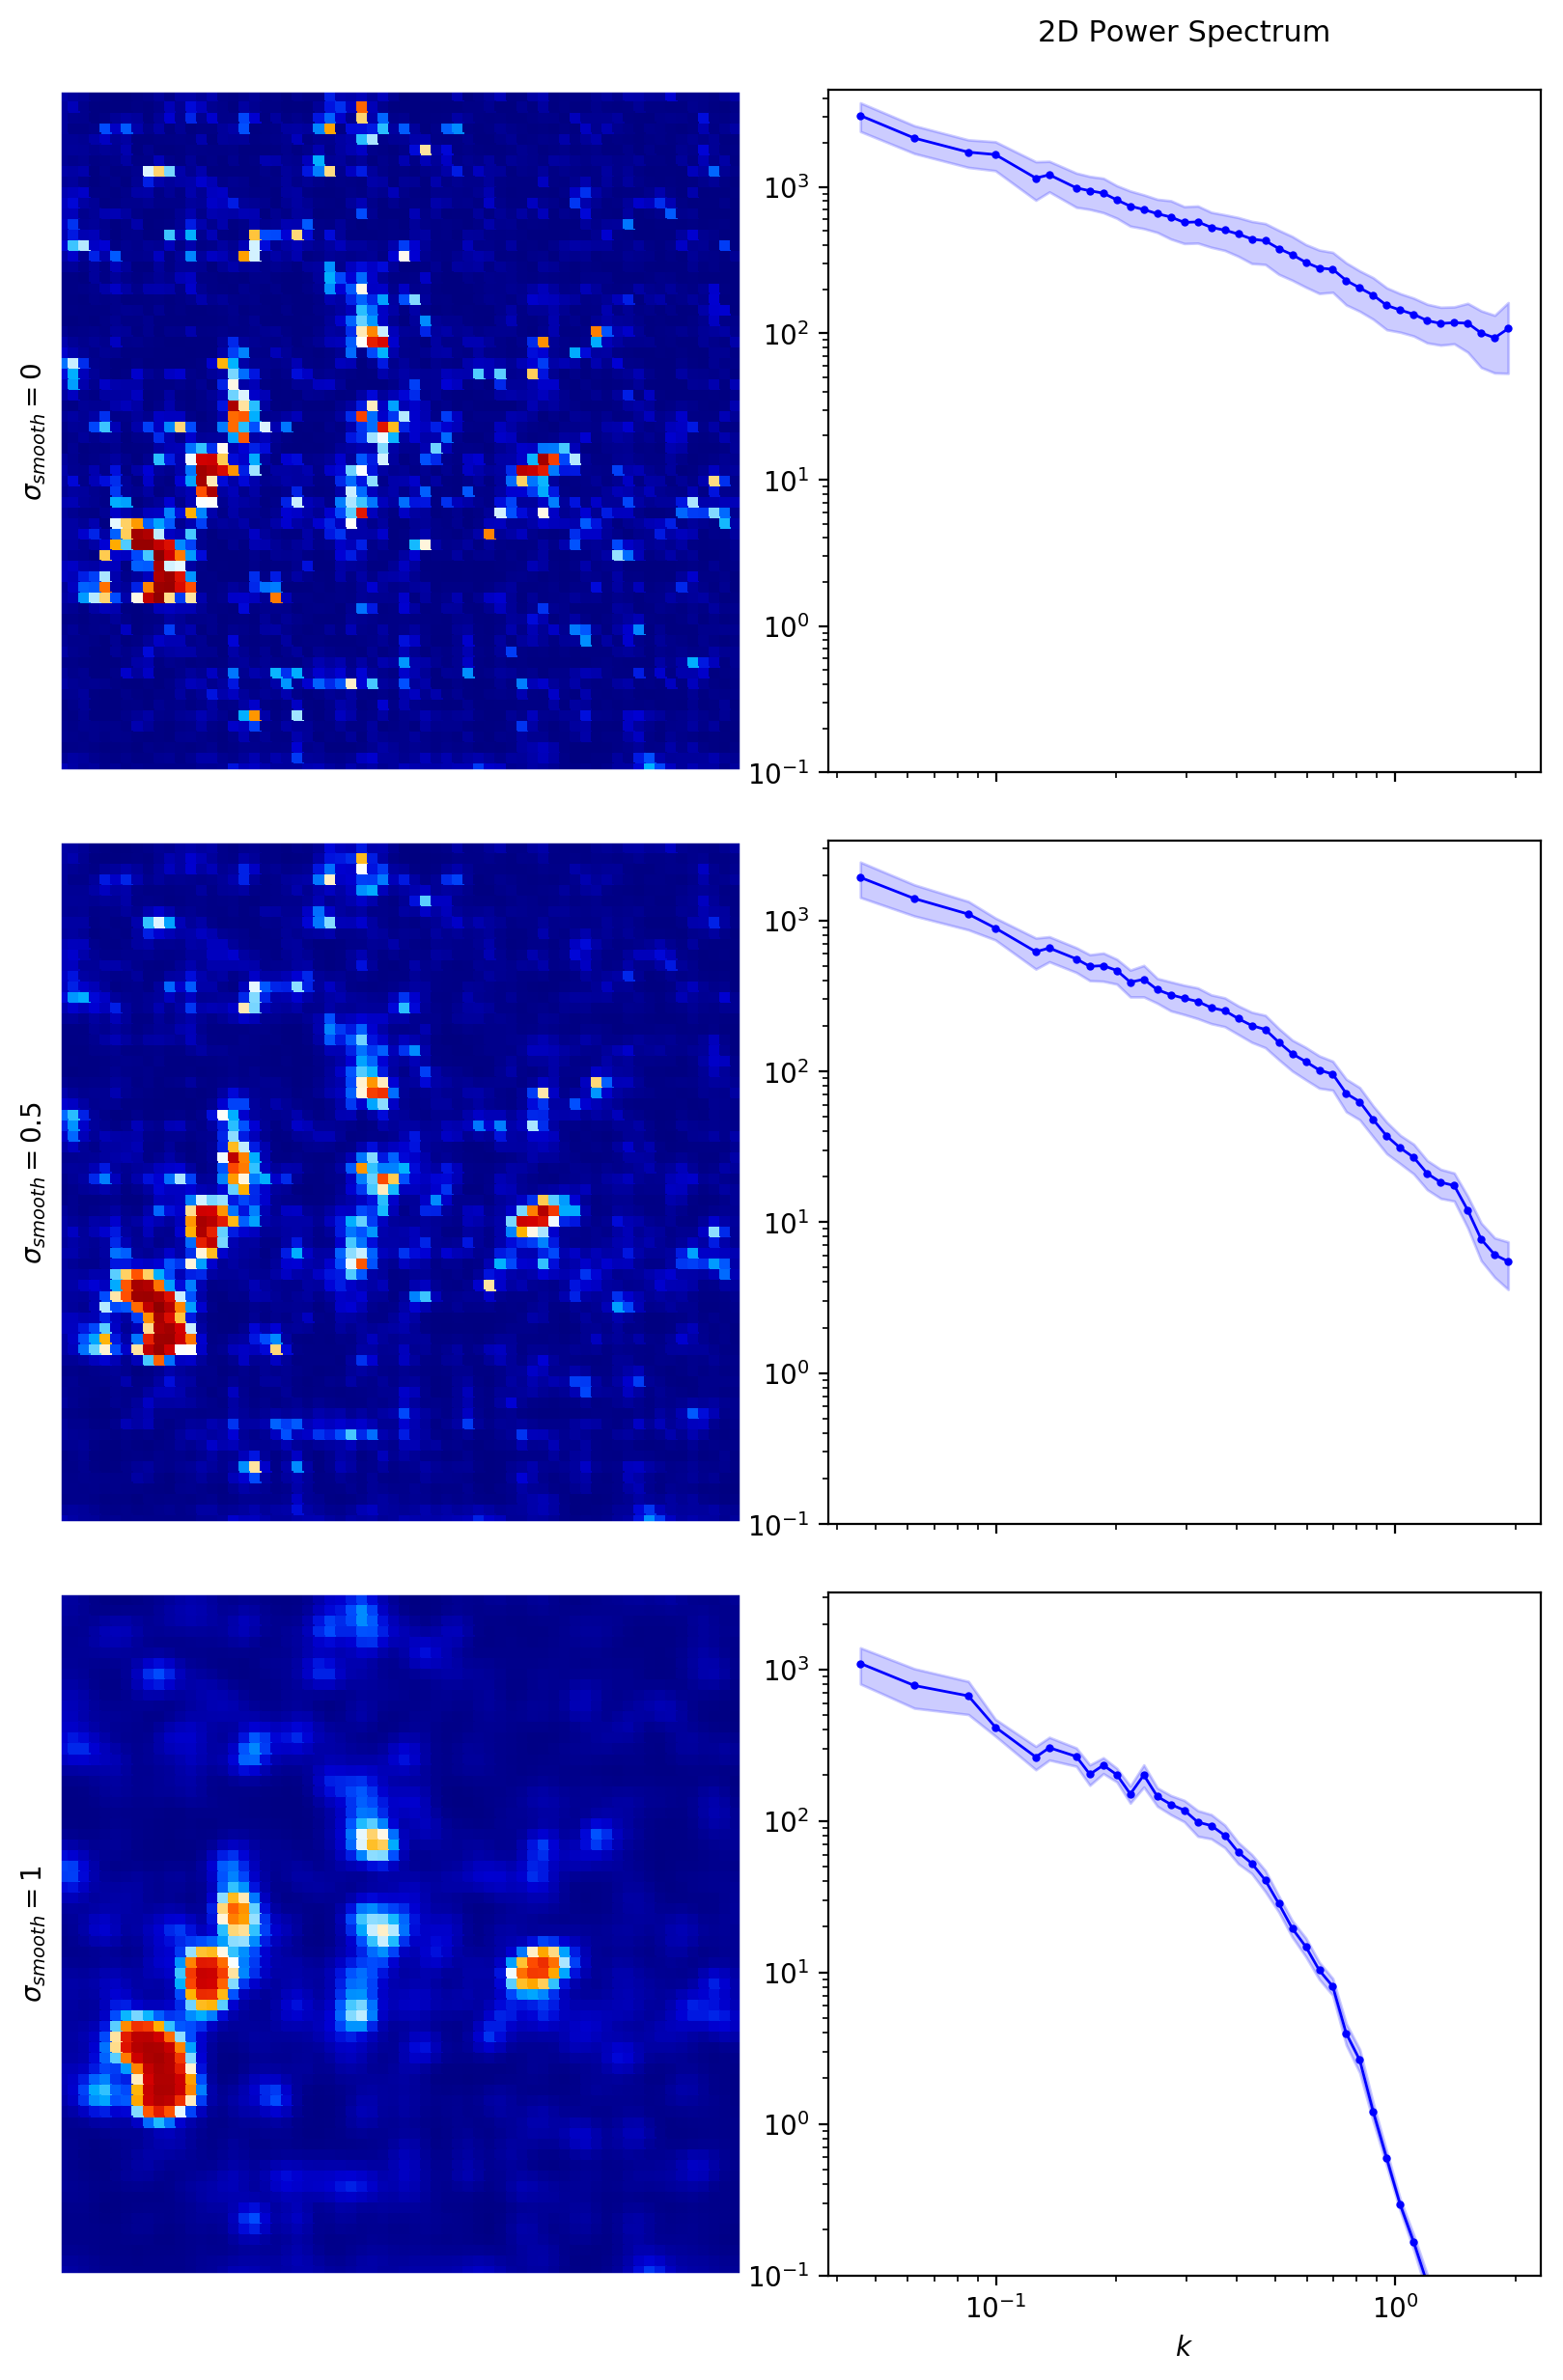

In [29]:
import plot

plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
